# Chapter 1: The contrast-dependence of spatial frequency tuning
Here, we'll organize (better than has been organized in the predecesor notebooks [descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]) the analysis for chapter 1 of my thesis.

Last access (y.m.d): 22.08.04  
Last update (y.m.d): 22.07.26  

### Table of contents

- Initialize  
- Gather data
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Tuning shifts with contrast **(1)**
  - Characteristic frequency, i.e. $f_c$
  - Bandwidth
  - sf70
- Shifts with contrast, refined view  **(2)**
  - Trajectory of metric (usually $f_c$) against contrast
      - Violinplot of distr. of bootstrap slopes ($\delta(x)$ across contrast) per cell
      - Plot distribution of fit slope across cells
  - Scatter plot of sf70 - high contrast to {1/3rd contrast, low contrast)
- Mechanism (DoG analysis) **(3)**
    - i.e. Sach plot

## Initialize

In [1345]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [1346]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots0

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

In [1572]:
autoreload.reload(hf);

In [1652]:
whichArea = 'V1' ; # 'LGN' or 'V1'
# whichArea = 'LGN'; # 'LGN' or 'V1'
wMods = 0 if whichArea == 'V1' else 0; # if wMods 
wModStr = '_wMods' if wMods else ''

if whichArea == 'V1':
    whichMod = 3; # applies only for V1
    jointType = 9 if whichMod==3 else 7;
else:
    whichMod = 1; # applies only for V1, anyway...
    jointType = 7;
inclBB = True

alt_suffix = '' if inclBB else '_noBB';

cut_by_slope = 0; # if cut_by_slope, we cut all cells that will not meet the #of conditions for cFreq slope-fitting;
# --- otherwise, we just make sure that there's at least one condition above threshold...
need_for_slope = 3 if whichArea=='LGN' else 3; # if X, then we need X contrast conditions to fit a slope
# need_for_slope = 3 if whichArea=='LGN' else 2; # if X, then we need X contrast conditions to fit a slope

toGroup = 'simple' if whichArea == 'V1' else 'triType'; # triType is 'magno', 'parvo', 'other'

fitBase = '220730' if whichArea == 'LGN' else '220707vEs'; # descriptive fits (rvc,SF tuning)
# fitBase = '220702' if whichArea == 'LGN' else '220707vEs'; # descriptive fits (rvc,SF tuning)
# fitBase = '220609' if whichArea == 'LGN' else '220702'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

if whichArea == 'LGN':
    thresh = 0;
#     thresh = 65;
    if jointType == 0:
        suffix = '%s%s_220615_vT%02d_dvT%02d_jt0' % (whichArea, wModStr, thresh, thresh)
    if jointType == 2:
        suffix = '%s%s_220614_vT%02d_dvT%02d_jt2' % (whichArea, wModStr, thresh, thresh)
    elif jointType == 7:
        suffix = '%s%s_220730_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#         suffix = '%s%s_220704_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#         suffix = '%s%s_220613_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#         suffix = '%s%s_220629_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)

else:
    thresh = 0; # 70
#     suffix = '%s%s_220629_vT%02d_dvT%02d_m%dj%d%s' % (whichArea, wModStr, thresh, thresh, whichMod, jointType, alt_suffix)
#     suffix = '%s%s_220704_vT%02d_dvT%02d_m%dj%d%s' % (whichArea, wModStr, thresh, thresh, whichMod, jointType, alt_suffix)
#     suffix = '%s%s_220708_vT%02d_dvT%02d_m%dj%d%s' % (whichArea, wModStr, thresh, thresh, whichMod, jointType, alt_suffix)
    suffix = '%s%s_220731vE_vT%02d_dvT%02d_m%dj%d%s' % (whichArea, wModStr, thresh, thresh, whichMod, jointType, alt_suffix)
#     suffix = '%s%s_220721_vT%02d_dvT%02d_m%dj%d%s' % (whichArea, wModStr, thresh, thresh, whichMod, jointType, alt_suffix)

try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);

slope_spec = '_slp%02d' % need_for_slope if cut_by_slope==1 else '';

saveName = 'figures/reports/ch1/%s%s/' % (suffix, slope_spec) # for one save name for all figures
save_loc = base_dir + saveName;

#### Trim the jointList on some criteria?

In [1653]:
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > VarExplThresh) 
# altA: single grating tuning curve at high contrast must have non-nan varExpl (i.e. > varExplThresh) 
# --- for the diff-of-gauss tuning fit

# Get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

prevCells = len(jointList)
if cut_by_slope:
    critA = np.where([np.sum(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0])) >= need_for_slope for x in sorted(jointList.keys())])[0]
else:
    critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]
# critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]


jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 26 cells (19.12% of the original 136)


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Now, put this list of dictionaries into a pandas dataframe for better plotting (hacky)

- First, create a pandas data frame
- Then, json "normalize" each top-level dictionary (e.g. metadata) into it's own dataframe
- Finally, combine _those_ dataframes into one

In [1654]:
# ref_slopes = [];
# aE = hf.np_smart_load('altExp/structures/descrFitsHPC_220702_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
# v1 = hf.np_smart_load('V1/structures/descrFitsHPC_220702_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')

# ref_slopes.extend([-aE[x]['paramList'][0][1] if np.all(~np.isnan(aE[x]['paramList'][0])) else np.nan for x in range(8)])
# ref_slopes.extend([-v1[x]['paramList'][0][1] if np.all(~np.isnan(v1[x]['paramList'][0]))  else np.nan for x in range(81)])
# ref_slopes = np.array(ref_slopes)

# nu_slopes = [];
# aE = hf.np_smart_load('altExp/structures/descrFitsHPC_220702vE_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
# v1 = hf.np_smart_load('V1/structures/descrFitsHPC_220702vE_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')

# nu_slopes.extend([-aE[x]['paramList'][0][1] if np.all(~np.isnan(aE[x]['paramList'][0])) else np.nan for x in range(8)])
# nu_slopes.extend([-v1[x]['paramList'][0][1] if np.all(~np.isnan(v1[x]['paramList'][0]))  else np.nan for x in range(81)])
# nu_slopes = np.array(nu_slopes)

In [1655]:
# inds_match = np.logical_and(~np.isnan(nu_slopes), ~np.isnan(ref_slopes))

# plt.figure(figsize=(10,10))
# plt.plot([-1,1],[-1,1],'k--')
# plt.scatter(nu_slopes, ref_slopes);
# plt.xlabel('lim. con slope')
# plt.ylabel('all con slope')
# plt.title('Median %.3f|%.3f (x|y)' % (np.nanmedian(nu_slopes[inds_match]), np.nanmedian(ref_slopes[inds_match])));

In [1656]:
ohno = pd.DataFrame.from_dict(jointList) #, orient='index')

meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
# supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

mega = pd.concat((meta, metr, modl, basc), axis=1)

In [1657]:
colors = [];

srt_group = False;

# classify as simple or complex [FOR USE WITH V1]
simple = mega['f1f0_ratio'] > 1
msk = np.copy(simple)
simple[~msk] = 'complex'
simple[msk] = 'simple'
mega['simple'] = simple

if whichArea == 'LGN':
    cellTypes = mega['cellType'];
    non_mp = np.logical_and(~(cellTypes=='parvo'), ~(cellTypes=='magno'))
    cellTypes[non_mp] = 'other'
    
    mega['triType'] = cellTypes;
    
# get color scheme
cnt = 0;
grp_names = [];
for nm, group in mega.groupby(toGroup, sort=srt_group):
    cnt += 1;
    grp_names.append(nm)
    
# colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
colors = sns.color_palette('colorblind', n_colors=cnt-1)
colors.append((0,0,0)); # add black!

if srt_group==False and whichArea=='LGN': # then let's switch the 2nd and 3rd
    colors_tmp=colors[1];
    colors[1]=colors[2];
    colors[2]=colors_tmp;

alph= 0.8/cnt
alphHist = 1; # the bins are non-overlapping now, so no need for transparency

In [1658]:
grp_names

['simple', 'complex']

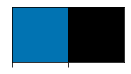

In [1659]:
sns.palplot(colors)

### How many of each cell type?

In [1660]:
print('%03d total cells:' % len(mega['cellType']))
if whichArea=='LGN':
    types = np.array([mega['cellType'][x] for x in range(len(mega['cellType']))])
    [print('  %02d of %s' % (np.sum(types==s),s)) for s in np.unique(types)]
else:
    types = np.array([mega['simple'][x] for x in range(len(mega['cellType']))])
    [print('  %02d of %s' % (np.sum(types==s),s)) for s in np.unique(types)]

110 total cells:
  64 of complex
  46 of simple


## 00. Set any overall parameters
For example, are we getting descr fits or DoG fits?

In [1661]:
isDog = 1; # 0 if descr; 1 if DoG
dog_suffix = 'dog_' if isDog else '';
dog_suffix_sv = '_dog' if isDog else '';
dog_suffix_plt = 'dog ' if isDog else ''

## 0. Distribution of tuning measures


<>:29: DeprecationWarning: invalid escape sequence \_


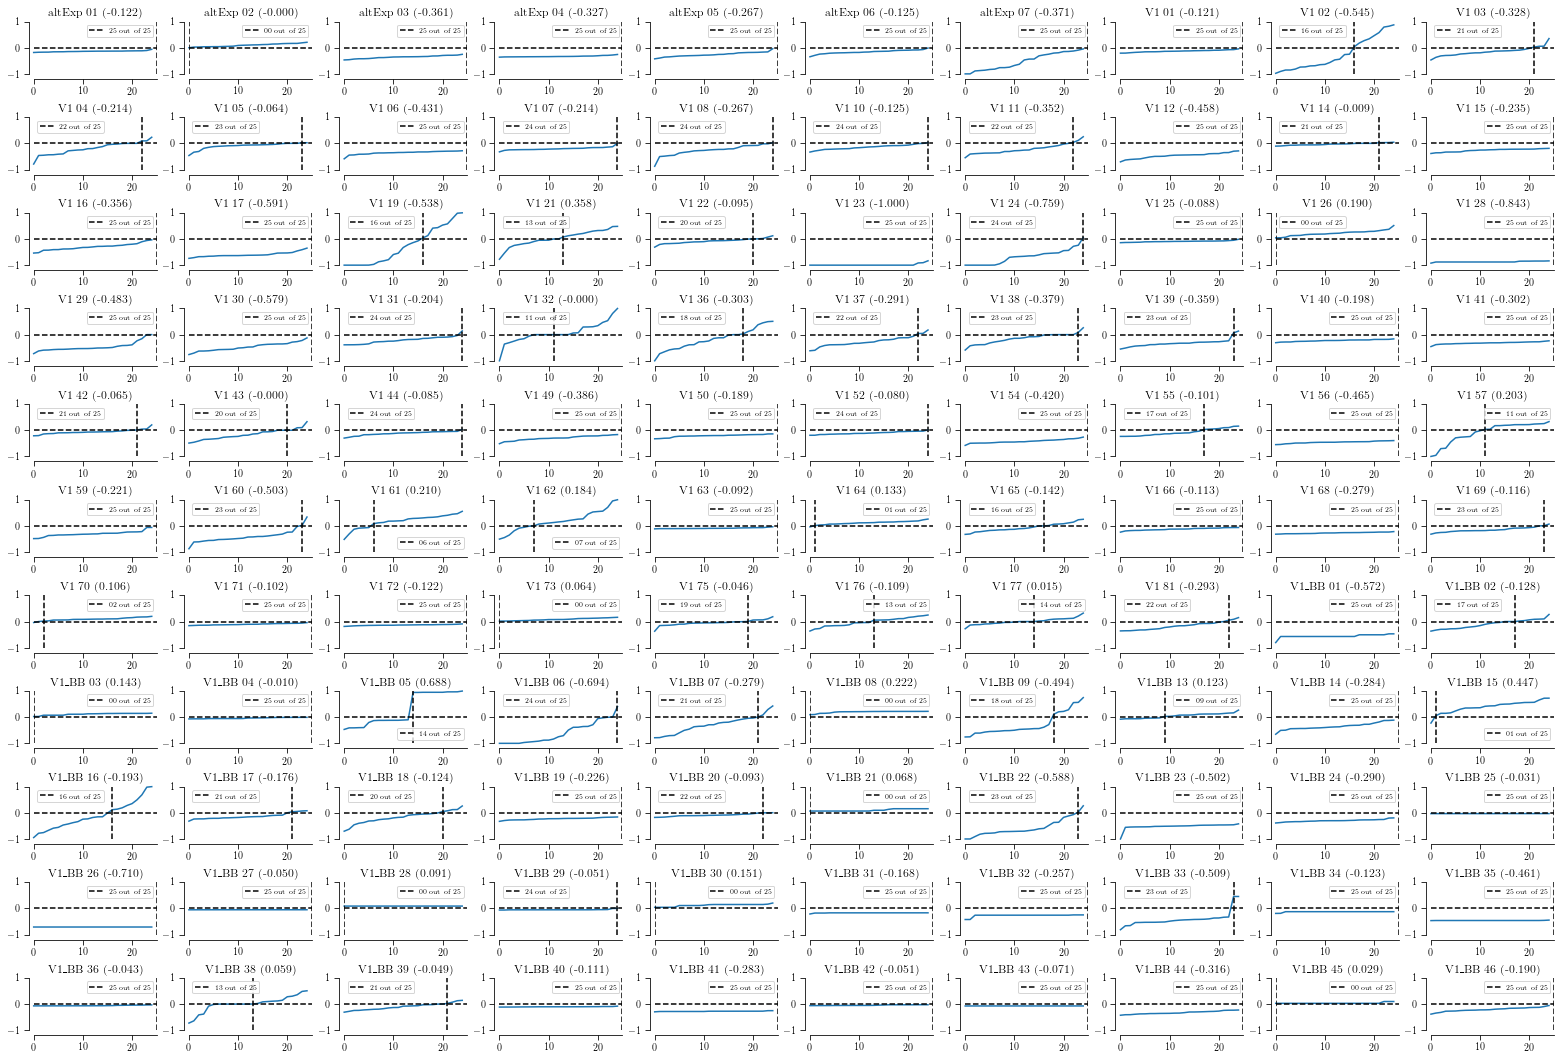

In [1662]:
if jointType >= 7: # only works if this is the case

    n_cells = len(jointList);

    n_rows = np.ceil(np.sqrt(n_cells)).astype(int);
    n_cols = np.ceil(n_cells/n_rows).astype(int);

    f, ax = plt.subplots(n_rows, n_cols, figsize=hf.set_size(tex_width, fraction=n_cols/3, subplots=(n_rows, n_cols)));
#     f, ax = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 4*n_rows));

    for ii,cl in enumerate(jointList.keys()):

        row_ind, col_ind = np.floor(ii/n_cols).astype(int), np.mod(ii, n_cols);

        og_slp = jointList[cl]['metrics']['dog_mod_slope'];
        slps = jointList[cl]['metrics']['boot_dog_mod_slope'];

        if slps is None:
            continue;
        
        ax[row_ind, col_ind].plot(sorted(slps), clip_on=False)

        n_lt0 = len(slps)-np.sum(slps>0);
        ax[row_ind, col_ind].axvline(n_lt0, color='k', linestyle='--', label='%02d out of %02d' % (n_lt0, len(slps)))
        ax[row_ind, col_ind].axhline(0, color='k', linestyle='--')
        ax[row_ind, col_ind].legend(fontsize='x-small');
        expdir = jointList[cl]['metadata']['fullPath'].split('/')[-3]
        cn = jointList[cl]['metadata']['cellNum']
        ax[row_ind, col_ind].set_title('%s %02d (%.3f)' % (expdir.replace('_','\_'), cn, og_slp))
        ax[row_ind, col_ind].set_xlim([0,len(slps)]);
        ax[row_ind, col_ind].set_ylim([-1, 1])

    f.tight_layout();
    sns.despine(offset=5)

    # now save
    saveName = '00_00_jt7_allBootSlopes.pdf'
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

In [1663]:
#######################
#######################
#######################
#######################
#######################
#######################

In [1664]:
com, _ = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0, valIsFrac=True)
var, _ = hf.jl_get_metric_byCon(jointList, 'sfVar', conVal=1.0, disp=0, valIsFrac=True)

pSf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
pSf_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_stdLog' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
# sf70
sf70, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
sf70_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conVal=1.0,
                                        disp=0, valIsFrac=True)
sf70_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
sf70_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# charFreq
cFreq, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=1.0, disp=0, valIsFrac=True)
cFreq_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conVal=1.0,
                                        disp=0, valIsFrac=True)
cFreq_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
cFreq_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# bwHalf
bwHalf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_std, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_std' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=0.33, disp=0, 
                                         valIsFrac=True, conTol=0.065)

mega['com_h'] = com
mega['var_h'] = com

mega['pSf_mn'] = pSf
mega['pSf_stdLog'] = pSf_stdLog
mega['sf70_mn'] = sf70
mega['sf70_stdLog'] = sf70_stdLog
mega['sf70_mn_third'] = sf70_third
mega['sf70_stdLog_third'] = sf70_stdLog_third
mega['charFreq_mn'] = cFreq
mega['charFreq_stdLog'] = cFreq_stdLog
mega['charFreq_mn_third'] = cFreq_third
mega['charFreq_stdLog_third'] = cFreq_stdLog_third
mega['bwHalf_mn'] = bwHalf
mega['bwHalf_std'] = bwHalf_std
mega['bwHalf_mn_third'] = bwHalf_third

if whichArea == 'LGN':
    mega['conGain_max'] = np.array([np.nanmax(mega['conGain'][x][0]) for x in mega['conGain'].keys()])

In [1665]:
# simple lin. regression
def fn(B, x):
    return B[0]*x + B[1]
linear = odrpack.Model(fn)

In [1666]:
highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % dog_suffix, 0, 1);

##### Show that pSf and sf70 {and then charFreq} are correlated

Beta: [1.71031227 1.54519233]
Beta Std Error: [1.23354256e-04 9.18139698e-05]
Beta Covariance: [[1.40263935e-12 1.04032025e-12]
 [1.04032025e-12 7.77061282e-13]]
Residual Variance: 10848.314336963413
Inverse Condition #: 0.0370881637837504
Reason(s) for Halting:
  Sum of squares convergence


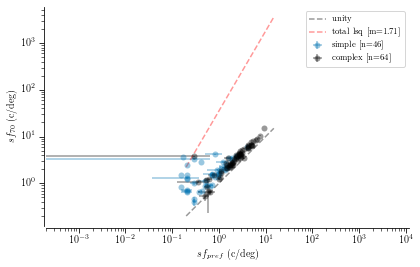

In [1667]:
saveName = '00_00_pSf_sf70_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()

plt.figure(figsize=hf.set_size(width=tex_width));
# plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup, sort=srt_group)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['sf70_mn']));
    plt.errorbar(group['pSf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

# f.tight_layout();
sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Beta: [0.94893114 1.13759506]
Beta Std Error: [0.08528777 0.05809696]
Beta Covariance: [[4.85020332e-07 3.30228516e-07]
 [3.30228516e-07 2.25057363e-07]]
Residual Variance: 14997.318237704985
Inverse Condition #: 0.012818244667257122
Reason(s) for Halting:
  Sum of squares convergence


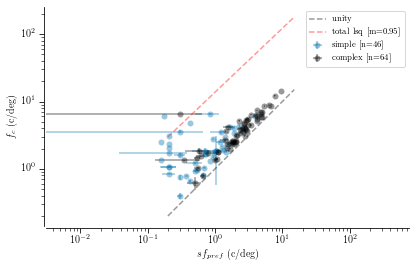

In [1668]:
saveName = '00_00alt_pSf_charFreq_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(cFreq[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=cFreq_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()

plt.figure(figsize=hf.set_size(width=tex_width));

grouped = mega.groupby(toGroup, sort=srt_group)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['charFreq_mn']));
    plt.errorbar(group['pSf_mn'], group['charFreq_mn'], yerr=group['charFreq_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$f_{c}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Plot distribution of sf70 at highContrast

In [1669]:
sf70bins = np.linspace(-2, 4, 13)

In [1670]:
def bin_offsets(nBins, width):
    if np.mod(nBins,2) == 0: # i.e. even # of bins
        return width*np.linspace(-0.5-(nBins/2-1), 0.5+(nBins/2-1), nBins)
    else: # i.e. odd # of bins
        return width*np.linspace(-np.floor(nBins/2), np.floor(nBins/2), nBins)

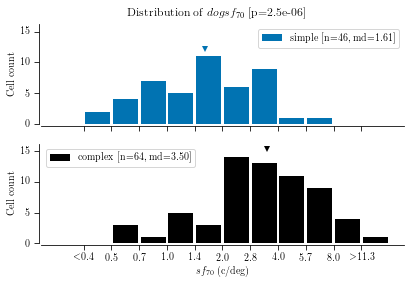

In [1671]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

use_norm=False;
norm_str = '_normed' if use_norm else '';

saveName = '00_01_sf70%s%s%s.pdf' % (lbl, dog_suffix_sv, norm_str)

nrow=len(grp_names);
f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(1,1))),
                     sharex=True, sharey=True)

grouped = mega.groupby(toGroup, sort=srt_group)

# gather and calculate
bins = sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = hist_width*stepSize;

bottom=np.zeros((len(binPlotLocs), ));

for (i, (name, group)), clr in zip(enumerate(grouped), colors):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['sf70_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['sf70_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    to_use = vals_norm if use_norm else vals;
    
    ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    ax[i].plot(np.log2(mdn), 1.1*np.max(to_use), 'v', color=clr)
    
    tickStrs = ['%.1f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '$<$%s' % tickStrs[0];
    tickStrs[-1] = '$>$%s' % tickStrs[-1];
    ax[i].set_xticks(tickVals);
    ax[i].set_xticklabels(tickStrs);
    
    ax[i].legend()
    ax[i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if i==nrow-1:
        ax[i].set_xlabel(r'$sf_{70}$ (c/deg)');
        
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))

ttest = ss.ttest_ind(*to_comp);
f.suptitle(r'Distribution of $%ssf_{70}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue), y=hist_ytitle)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


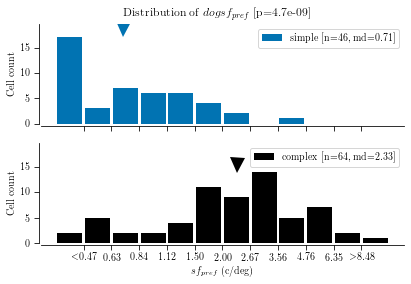

In [1672]:
saveName = '00_01alt_pSf_highCon%s.pdf' % dog_suffix_sv

nrow=len(grp_names);
f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
                     sharex=True, sharey=True)

grouped = mega.groupby(toGroup, sort=srt_group)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = hist_width*stepSize;

for (i, (name, group)), clr in zip(enumerate(grouped), colors):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['pSf_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['pSf_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    to_use = vals_norm if use_norm else vals;
    
    ax[i].plot(np.log2(mdn), 1.1*np.max(to_use), 'v', color=clr, markersize=15)
    
    ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '$<$%s' % tickStrs[0];
    tickStrs[-1] = '$>$%s' % tickStrs[-1];
    ax[i].set_xticks(tickVals);
    ax[i].set_xticklabels(tickStrs);

    ax[i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if i==nrow-1:
        ax[i].set_xlabel(r'$sf_{pref}$ (c/deg)');
    ax[i].legend()
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    else:
        to_comp.append(hf.nan_rm(group['pSf_mn']))

ttest = ss.ttest_ind(*to_comp);
f.suptitle(r'Distribution of $%ssf_{pref}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue), y=hist_ytitle)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
# f.tight_layout();
sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


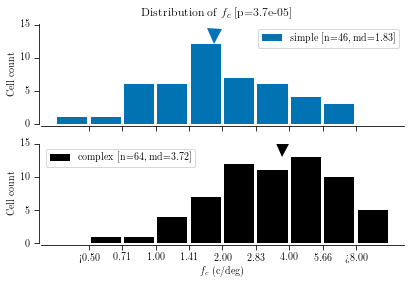

In [1673]:
nrow=len(grp_names);
f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
                     sharex=True, sharey=True)

use_norm = False;
    
norm_str = '_normed' if use_norm else '';

saveName = '00_01alt_charFreq%s.pdf' % (norm_str)

grouped = mega.groupby(toGroup, sort=srt_group)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 11);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = hist_width*stepSize

for (i, (name, group)), clr in zip(enumerate(grouped), colors):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['charFreq_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    to_use = vals_norm if use_norm else vals;
    
    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['charFreq_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];


    ax[i].plot(np.log2(mdn), 1.1*np.max(to_use), 'v', color=clr, markersize=15)
    ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    ax[i].set_xticks(tickVals);
    ax[i].set_xticklabels(tickStrs);
   
    ax[i].legend()
    ax[i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if i==nrow-1:
        ax[i].set_xlabel(r'$f_c$ (c/deg)');
        
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['charFreq_mn']))
    else:
        to_comp.append(hf.nan_rm(group['charFreq_mn']))

ttest = ss.ttest_ind(*to_comp);
f.suptitle(r'Distribution of $f_c$ [p=%.1e]' % (ttest.pvalue), y=hist_ytitle);

sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Max. con gain (if LGN, only)

In [1674]:
if whichArea == 'LGN':
    
    nBins = 8
    conGain_bins = np.log10(np.geomspace(12.5, 12.5*np.power(2, nBins-1), nBins));
#     conGain_bins = np.log10(np.geomspace(25, 25*np.power(2, nBins-1), nBins));
    
    use_norm = False;
    
    norm_str = '_normed' if use_norm else '';
    
    saveName = '00_01alt_conGain%s.pdf' % (norm_str)

    nrow=len(grp_names);
    f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
                         sharex=True, sharey=True)

    grouped = mega.groupby(toGroup, sort=srt_group)

    # gather and calculate
    bins = conGain_bins
    stepSize = (bins[-1] - bins[0])/(len(bins)-1);
    binPlotLocs = bins[1:] - 0.5*stepSize;
    clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

    tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

    to_comp = [];
    
    width = hist_width*stepSize
    offsets = bin_offsets(cnt, width);
    
    bottom = np.zeros((len(binPlotLocs), ))
    
    for (i, (name, group)), clr in zip(enumerate(grouped), colors):
        clipped = [np.clip(np.log10(x), clipLow, clipHigh) for x in hf.nan_rm(group['conGain_max'])];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        to_use = vals_norm if use_norm else vals;

        # calculate
        # nSF = [len(x) for x in psfs_clipped]
        mdn = np.nanmedian(group['conGain_max']);
        # mnSF = [np.nanmean(x) for x in psfs];
        gmn = gmean(hf.nan_rm(group['conGain_max']));

        ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
        ax[i].plot(np.log10(mdn), 1.1*np.max(to_use), 'v', color=clr)

        tickStrs = ['%d' % np.round(np.power(10, x)) for x in tickVals];
        tickStrs[0] = '$<$%s' % tickStrs[0];
        tickStrs[-1] = '$>$%s' % tickStrs[-1];
        ax[i].set_xticks(tickVals);
        ax[i].set_xticklabels(tickStrs);
        ax[i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
        ax[i].legend()
        if i == nrow-1:
            ax[i].set_xlabel('Contrast gain');

        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(hf.nan_rm(group['conGain_max']))
        else:
            to_comp.append(hf.nan_rm(group['conGain_max']))
            
    ttest = ss.ttest_ind(*to_comp);
    f.suptitle('Distribution of contrast gain [p=%.1e]' % ttest.pvalue, y=hist_ytitle)

    sns.despine(offset=sns_offset);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


##### Plot distribution of bwHalf at highContrast

In [1675]:
bwHalfbins = np.linspace(1, 5, 9)

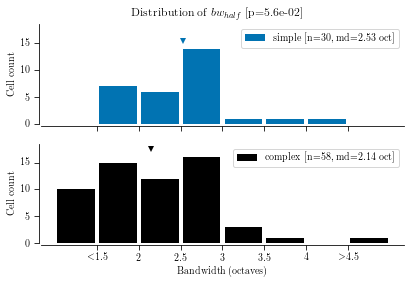

In [1676]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'
use_norm = False;

fewer_ticks = False;

norm_str = '_normed' if use_norm else '';

saveName = '00_02_bwHalf%s%s.pdf' % (lbl, norm_str)

non_nan = ~np.isnan(pSf);

nrow=len(grp_names);
f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
                     sharex=True, sharey=True)

grouped = mega.groupby(toGroup, sort=srt_group)

# gather and calculate
bins = bwHalfbins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
if fewer_ticks:
    tickVals = tickVals[0::2]; # every other

to_comp = [];

width = hist_width*stepSize

for (i, (name, group)), clr in zip(enumerate(grouped), colors):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['bwHalf_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    to_use = vals_norm if use_norm else vals;
    
    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['bwHalf_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
        label='%s [n=%d, md=%.2f oct]' % (name, np.sum(vals), mdn), alpha=alphHist);
    ax[i].plot(mdn, 1.1*np.max(to_use), 'v', color=clr)

    tickStrs = ['%d' % x if int(x)==x else '%.1f' % x for x in tickVals];
    tickStrs[0] = '$<$%s' % tickStrs[0];
    tickStrs[-1] = '$>$%s' % tickStrs[-1];
    ax[i].set_xticks(tickVals);
    ax[i].set_xticklabels(tickStrs);

    ax[i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    ax[i].legend()
    if i == nrow-1:
        ax[i].set_xlabel('Bandwidth (octaves)');

    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))

ttest = ss.ttest_ind(*to_comp);
    
f.suptitle(r'Distribution of $bw_{half}$ [p=%.1e]' % ttest.pvalue, y=hist_ytitle)

sns.despine(offset=sns_offset);

#now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Ask if sf70 and bwHalf are correlated?

Beta: [-0.37802424  1.04059522]
Beta Std Error: [0.03262881 0.06635516]
Beta Covariance: [[ 1.35435743e-05 -2.73764647e-05]
 [-2.73764647e-05  5.60118732e-05]]
Residual Variance: 78.60846314222265
Inverse Condition #: 0.0031968677829679435
Reason(s) for Halting:
  Sum of squares convergence


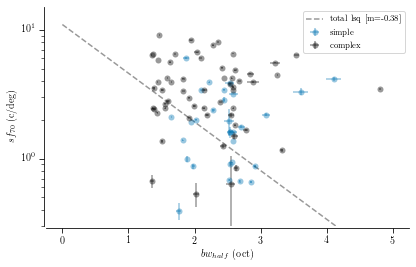

In [1677]:
saveName = '00_03a_bwHalf_sf70%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

sf70[sf70_stdLog==0] = 1e-3
bwHalf_std[bwHalf_std==0] = 1e-3

mydata = odrpack.RealData(bwHalf[non_nan], np.log10(sf70[non_nan]), 
                          sx=bwHalf_std[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(bwHalf[non_nan], np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=hf.set_size(tex_width));

grouped = mega.groupby(toGroup, sort=srt_group)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['bwHalf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)

### Plot unity line, model; set up legend
# plt.xscale('log')
plt.yscale('log')
plt.ylim([3e-1, 1.5e1])
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

xvals = np.linspace(0, 5, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, xvals)), 
         'k--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$bw_{half}$ (oct)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


Beta: [2.39373261 0.29648628]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Beta: [ 2.22271575 -0.06608944]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected


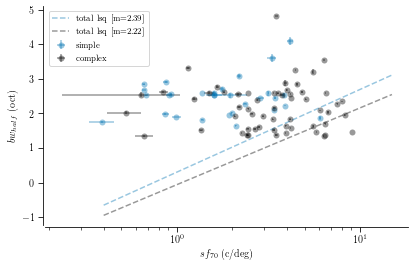

In [1678]:
saveName = '00_03b_sf70_bwHalf%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3


plt.figure(figsize=hf.set_size(tex_width));

grouped = mega.groupby(toGroup, sort=srt_group)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['sf70_mn'], group['bwHalf_mn'], xerr=group['sf70_stdLog'], yerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['bwHalf_mn']));
    
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], 
                              sy=group['bwHalf_std'][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)), 
             '--', color=clr, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
    

### Plot unity line, model; set up legend
plt.xscale('log')
# plt.yscale('log')
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

plt.legend(fontsize='small')
plt.ylabel(r'$bw_{half}$ (oct)')
plt.xlabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [1679]:
def match_lengths(x):
    # fill with NaN to make sure that all lists in the array have the same length
    max_len = np.max([len(xp) for xp in x])
    for i, xp in enumerate(x):
        if len(xp) < max_len:
            tmp = np.nan * np.zeros((max_len, ));
            tmp[0:len(xp)] = xp
            x[i] = tmp
            
    return np.stack(x)

## 2. Shifts with contrast, refined view
Per discussion in VNL, we should try (or rather, revive) to consider the whole trajectory of sf70 (or bandwidth, or else) with contrast

### 01. Plot metric (e.g. sf70) against contrast - for all cells separately and then together

In [1680]:
import scipy.optimize as opt

In [1681]:
def fn(x, a, b):
    return b + a*x;
#     return b + np.log10(a)*np.log10(x);


In [1682]:
# For below plots...
# First, let's check which jointTypes are in this jointList --
# -- if it's 7, then that means we directly fit the slope
jnts = mega['jointType'].unique();

incl_slopeMod_slope = True;

# from_slopes = False; # make the plots from the slopes???
from_slopes = True;

if len(jnts)==1 and jnts[0]>=7 and from_slopes:
    slope_direct = True
else:
    slope_direct = False;

if incl_slopeMod_slope and not slope_direct: # then we should load the slopes, otherwise

    if whichArea == 'LGN':
    
        slp_date = '220702vE';
#         slp_date = '220610';
        isHPC = 1;
        phAdv = 1; # phAdv or no?
        loss_type = 2; # sqrt
        DoGmodel = 1; # sach DoG
        slps = [];
        # first, LGN
        data_dir = 'LGN/structures/'
        descrBase = 'descrFits%s_%s' % ('HPC' if isHPC else '', slp_date)
        slp_mod = hf.np_smart_load('%s%s' % (data_dir, hf.descrFit_name(loss_type, descrBase=descrBase, 
                                                  modelName=hf.descrMod_name(DoGmodel), joint=7, phAdj=phAdv)))
        slps_lgn = [-slp_mod[x]['paramList'][0][1] if np.all(~np.isnan(slp_mod[x]['paramList'][0])) else np.nan for x in range(len(slp_mod.keys()))];
        intrs_lgn = [slp_mod[x]['paramList'][0][0] if np.all(~np.isnan(slp_mod[x]['paramList'][0])) else np.nan for x in range(len(slp_mod.keys()))];
        slps.extend(slps_lgn)

        # then, Sach
        data_dir = 'LGN/sach/structures/'
        descrBase = 'descrFits%s_s%s' % ('HPC' if isHPC else '', slp_date)
        slp_mod = hf.np_smart_load('%s%s' % (data_dir, hf.descrFit_name(loss_type, descrBase=descrBase, 
                                                  modelName=hf.descrMod_name(DoGmodel), joint=7, phAdj=phAdv)))
        slps_sach = [-slp_mod[x]['paramList'][1] if np.all(~np.isnan(slp_mod[x]['paramList'])) else np.nan for x in range(len(slp_mod.keys()))];
        intrs_sach = [slp_mod[x]['paramList'][0] if np.all(~np.isnan(slp_mod[x]['paramList'])) else np.nan for x in range(len(slp_mod.keys()))];
        slps.extend(slps_sach)
    
    else: # i.e. V1...
        
        slp_dates = ['220707vEs', '220721vEs'];
#         slp_date = '220609';
        phAdjs = [0,1];
        isHPC = 1;
        loss_type = 2; # sqrt
        DoGmodel = whichMod; # specified above
        slps = []; inters = [];

        from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
        from helper_fcns_sfBB import get_resp_str
        
        for curr_dir, slp_date, phAdj in zip(['altExp', 'V1'], slp_dates, phAdjs):#, 'V1_BB', 'V1_orig']:
            try:
                data_dir = '%s/structures/' % curr_dir
                descrBase = 'descrFits%s_%s' % ('HPC' if isHPC else '', slp_date)
                slp_mod = hf.np_smart_load('%s%s' % (data_dir, hf.descrFit_name(loss_type, descrBase=descrBase, 
                                                          modelName=hf.descrMod_name(DoGmodel), phAdj=phAdj, joint=9)))
                if curr_dir == 'V1_BB': # then we have work to do per cell
                    dl = hf.np_smart_load('V1_BB/structures/%s' % hf.get_datalist('V1_BB/'));
                    slps_curr = []; intrs_curr = [];
                    for ii, expName in enumerate(dl['unitName']):
                        cell = hf.np_smart_load('V1_BB/structures/%s_sfBB.npy' % expName);
                        expInfo = cell['sfBB_core']; # we ONLY analyze sfBB_core in this jointList (as of 21.05.10)                                                                                                                                                                            
                        f1f0_ind = bb_compute_f1f0(expInfo)[0] > 1; # if simple, then index with 1; else, 0                                                                                                                                                                                    
                        respKey = get_resp_str(f1f0_ind); # as string, either 'dc', or 'f1'
                        try:
                            ### CHECK THAT THIS WORKS WITH NAN/missing values?
                            slps_curr.extend([-slp_mod[ii][respKey]['mask']['paramList'][0]]);
                            intrs_curr.extend([slp_mod[ii][respKey]['mask']['paramList'][1]]);
                        except:
                            slps_curr.extend([np.nan]);
                            intrs_curr.extend([np.nan]);
                else:
                    slps_curr = [-slp_mod[x]['paramList'][0][1] if np.all(~np.isnan(slp_mod[x]['paramList'][0])) else np.nan for x in range(len(slp_mod.keys()))];
                    intrs_curr = [slp_mod[x]['paramList'][0][0] if np.all(~np.isnan(slp_mod[x]['paramList'][0])) else np.nan for x in range(len(slp_mod.keys()))];
                slps.append(slps_curr);
                inters.append(intrs_curr);
            except:
                slps.append([]); inters.append([]);

<>:62: DeprecationWarning: invalid escape sequence \_
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-p

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

<Figure size 469x289.858 with 0 Axes>

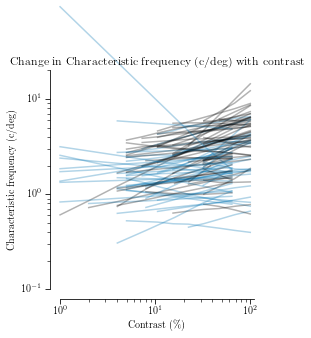

In [1683]:
cons_to_100 = True; # make the contrasts up to 100%? Or just 1?
specify_ticks = False; # choose specific ticks? or no?
full_plot = False; # disregard some smaller things that are bad for pub. plots, good only for diagn.
sd1 = True; # 1 S.D. or 2 S.D. (95% CI) error bars?

# metr = 'sf70'
metr = 'charFreq'
metr_nice = 'Characteristic frequency (c/deg)' if metr == 'charFreq' else metr;
metrIsLog = 1; # is this metric log?
var_suffix = 'stdLog' if metrIsLog else 'std';

con_mult = 100 if cons_to_100 else 1;

tick_str = '_tks' if specify_ticks else '';

norm = 0; # normalized?
norm_suffix = '_{norm}' if norm else '';

ylim = [1e-1, 2e1];

isDog = 1;
dog_suffix = 'dog_' if isDog else ''

# Mostly unchanged
disp = 0; # unchanged!
xlim = np.multiply(con_mult, [1e-2, 1.1]); # contrast
if sd1:
    low, ctr, high = 50-34.1, 50, 50+34.1; # get median, and bounds for 68% C.I.
else:
    low, ctr, high = 2.5, 50, 97.5; # get median, and bounds for 95% C.I.

mega_figure = plt.figure(figsize=hf.set_size(tex_width))

# names for savig
save_loc_indiv = save_loc + '02_01_trajIndiv_%s%s%s/' % (dog_suffix, metr, '_1sd' if sd1 else '_ci95')
# -- individual name will be made within the loop
saveName = '02_01_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix.replace('{', '').replace('}',''))

reg_slopes = np.nan * np.zeros((len(mega['cellType']), 2)); # we'll store the param. and it's std.
reg_slopes_boot = np.nan * np.zeros((len(mega['cellType']), 3)); # median slope with 95% C.I.
reg_slopes_boot_summary = np.nan * np.zeros((len(mega['cellType']), 3)); # median, mean slopes, std. of slopes
reg_slopes_boot_all = [];

# --- for each fit, let's also keep a list of the errors per data point and their associated contrasts
reg_slopes_errs = np.nan * np.zeros((len(mega['cellType']), ), dtype='O'); # we'll store the param. and it's std.
reg_slopes_cons = np.nan * np.zeros((len(mega['cellType']), ), dtype='O'); # we'll store the param. and it's std.

for ky in range(len(mega['cellType'])):
    
    plt.figure(figsize=hf.set_size(tex_width));
    
    curr_dir = mega['fullPath'][ky].split('/')[-3]
    curr_num = mega['cellNum'][ky];
    if whichArea == 'LGN':
        curr_isSach = True if 'sach' in curr_dir else False;
        curr_name = '' if curr_isSach else mega['expName'][ky];
    else:
        curr_name = mega['expName'][ky]
        
    curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
#     title = r'%s [%s]' % (curr_dir, curr_type)
    title = r'%s \#%02d:%s [%s]' % (curr_dir.replace('_','\_'), curr_num, curr_name.replace('_','\_'), curr_type)
    
    # get which contrasts will be plotting, corresponding indices
    curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
    val_inds = mega['val_con_by_disp'][ky][disp]; # should always be zero disp
    
    mtr = 'boot_%s%s_values' % (dog_suffix, metr)
    # then get the metric of interest
    curr_ref = mega['%s%s' % (dog_suffix,metr)][ky][disp, val_inds] # i.e. values not from bootstrapping
    curr_vals = mega[mtr][ky][disp, val_inds]
    curr_low, curr_med, curr_high = np.nanpercentile(curr_vals, [low, ctr, high], axis=1)
    curr_errs = np.abs([curr_low, curr_high] - curr_med); # -/+ is inferred in plt.errorbar call
#     curr_errs = np.nanstd(curr_vals, axis=1)
    # -- get the right color
    clr = colors[grp_names.index(curr_type)];
    
    # and plot! (this is the distribution of, e.g. char_freq --- we'll add the slopes later)
    plt.scatter(con_mult*curr_cons[val_inds], curr_med, color=clr,clip_on=False)#, s=70);
    plt.errorbar(con_mult*curr_cons[val_inds], curr_med, yerr=curr_errs, color=clr, clip_on=False);
    # -- with linear regression (on log-log, assuming both dims are log)
    ok_for_reg = np.where(~np.isnan(curr_med))[0];
    if slope_direct:       
        # and plot... for which we'll have to get the initial offset (using the intercept param)
        slp_key = 'dog_mod';
        init_slope = -mega['%s_slope' % slp_key][ky]; # negate to get change in fc (as opposed to xc) with con.
        init_interc = mega['%s_intercept' % slp_key][ky]; # no need to negate this...
        
        reg_slopes[ky] = [init_slope, np.nan];
        reg_slopes_cons[ky] = curr_cons[val_inds]
        save_suffix = '_modSlope'
        
        try:
            curr_slopes = -mega['boot_%s_slope' % slp_key][ky]; # again, negate
            reg_slopes_boot[ky] = [np.nanpercentile(curr_slopes, x) for x in [low, ctr, high]];
            reg_slopes_boot_summary[ky] = [reg_slopes_boot[ky,1], np.nanmean(curr_slopes), np.nanstd(curr_slopes)];
            reg_slopes_boot_all.append(curr_slopes);
            
            # the corrected intercept is given by the following (follows from equating the two approaches of getting f_c with contrast)
            adj_interc = np.log10(1/(np.pi*np.power(10,init_interc)))
            pmz = (init_slope, adj_interc);
            curr_std = np.nanstd(curr_slopes);
            conz = np.geomspace(curr_cons[val_inds][0], curr_cons[val_inds][-1], 50);
            pct_lt0 = 100*np.sum(curr_slopes<0)/len(curr_slopes);
            plt.plot(con_mult*conz, np.power(10, fn(np.log10(conz), *pmz)), 'k--', label=r'$m=%.2f \pm %.2f$ (%.2f\%% lt0)' % (pmz[0], curr_std, pct_lt0))
        except:
            pass;
    else:
        save_suffix = '_regSlope'
        if len(ok_for_reg) >= need_for_slope:
            mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
            curr_var = mega[mtr_var][ky][disp, val_inds]
            if np.any(np.isnan(curr_var[ok_for_reg])): # then just set curr_var equal to ones...
                curr_var = np.ones_like(curr_var); # i.e. equal variability...

            fine = opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_med[ok_for_reg]), 
                                 sigma=(curr_var[ok_for_reg]))
            pmz = fine[0];
            perr = np.sqrt(np.diag(fine[1])); # per https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
            conz = np.geomspace(curr_cons[val_inds][ok_for_reg][0], curr_cons[val_inds][ok_for_reg][-1], 50);
            reg_slopes[ky] = [pmz[0], perr[0]];
            if incl_slopeMod_slope:
                if whichArea == 'LGN':
                    curr_slope = slps_sach[curr_num-1] if curr_isSach else slps_lgn[curr_num-1];
                    curr_interc = intrs_sach[curr_num-1] if curr_isSach else intrs_lgn[curr_num-1];
                else:
                    # below is the order we've specified the experiments (given the above code)
                    if 'alt' in curr_dir:
                        ind = 0;
                    elif 'V1' in curr_dir:
                        if 'rig' in curr_dir:
                            ind=3;
                        elif 'BB' in curr_dir:
                            ind=2;
                        else:
                            ind=1; # regular 'ol V1
                    curr_slope = slps[ind][curr_num-1]; curr_interc = inters[ind][curr_num-1]
                # the corrected intercept is given by the following (follows from equating the two approaches of getting f_c with contrast)
                adj_interc = np.log10(1/(np.pi*np.power(10,curr_interc)))
                clr = 'r' if full_plot else 'k'
                alph = 0.5 if full_plot else 1;
                plt.plot(con_mult*conz, np.power(10, fn(np.log10(conz), curr_slope, adj_interc)), '%s--' % clr, alpha=alph, label=r'$mod_m=%.2f$' % (curr_slope))
            # --- let's also store the associated contrasts, errors
            if full_plot:
                plt.plot(con_mult*conz, np.power(10, fn(np.log10(conz), *pmz)), 'k--', label=r'$m=%.2f \pm %.2f$' % (pmz[0], perr[0]))
            reg_slopes_errs[ky] = np.log10(curr_med[ok_for_reg]) - fn(np.log10(curr_cons[val_inds][ok_for_reg]), *pmz); # data - model
            reg_slopes_cons[ky] = curr_cons[val_inds][ok_for_reg]

            ### Also do slopes per-boot
            curr_slopes = [];
            for bt_i in range(curr_vals.shape[-1]): # that's the boot value
                try:
                    curr_slopes.append(opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_vals[ok_for_reg, bt_i]))[0][0]);
                except:
                    curr_slopes.append(np.nan);
            reg_slopes_boot[ky] = [np.nanpercentile(curr_slopes, x) for x in [low, ctr, high]];
            reg_slopes_boot_summary[ky] = [reg_slopes_boot[ky,1], np.nanmean(curr_slopes), np.nanstd(curr_slopes)];
            reg_slopes_boot_all.append(curr_slopes);
        else:
            reg_slopes_boot_all.append([]);
            
    # --- and first, plot the reference values (i.e. those from the best fit)
    if full_plot:
        plt.scatter(con_mult*curr_cons[val_inds], curr_ref, facecolors='none', s=70, edgecolors='r', alpha=0.75, clip_on=False, marker='o', label='ref. values');
    # adjust figure
    plt.xscale('log');
    plt.xlabel(r'Contrast (\%)');
    if metrIsLog:
        plt.yscale('log');
        plt.axis('scaled');
    plt.ylabel('%s' % metr_nice);
    plt.ylim(ylim);
    plt.xlim(xlim);

    plt.legend()
       
    ax = plt.gca();
    from matplotlib.ticker import FuncFormatter
    for jj, axis in enumerate([ax.xaxis, ax.yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
#         axis.set_minor_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj == 0 and specify_ticks: # i.e. x-axis
            axis.set_ticks([1,3,10,30,100])
        elif jj == 1 and specify_ticks: # i.e. y-axis
            axis.set_ticks([0.3,1,3,10])

    plt.title(r'%s' % title);
    sns.despine(offset=sns_offset);
    
    # Save the current one
    saveName_indiv = '%s_%02d%s%s.pdf' % (curr_dir, curr_num, save_suffix, tick_str)
    
    if not os.path.exists(save_loc_indiv):
        os.makedirs(save_loc_indiv)
    pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
    f = plt.gcf();
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    plt.clf(); # close the plot
    
    # replot on the first one, too
    plt.figure(1);
    if norm:
        try:
            # normalize by the metric value at the highest valid contrast
            norm_ind = np.where(~np.isnan(curr_med))[0][-1];
            curr_med_norm = np.divide(curr_med, curr_med[norm_ind])
            plt.plot(con_mult*curr_cons[val_inds], curr_med_norm, color=clr, clip_on=False, alpha=0.3)
#             plt.errorbar(curr_cons[val_inds], curr_med_norm, curr_errs, color=clr, clip_on=False, alpha=0.3)
        except:
            pass
    else:
        plt.plot(con_mult*curr_cons[val_inds], curr_med, color=clr, clip_on=False, alpha=0.3)
#         plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False, alpha=0.3)

# at the end, fix up the overall figure
plt.figure(1);

plt.xscale('log');
plt.xlabel(r'Contrast (\%)')
if metrIsLog:
    plt.yscale('log')
    plt.axis('scaled')
plt.ylim(ylim);
plt.xlim(xlim);
plt.ylabel(r'%s%s' % (metr_nice, norm_suffix))
plt.title(r'Change in %s with contrast' % metr_nice)

sns.despine(offset=10)

# Save the overall plot
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()
# plt.clf() # close the plot


# And save the slopes in the overall structure
mega['conSlope_%s%s' % (dog_suffix, metr)] = reg_slopes[:,0]
mega['conSlope_%s%s_std' % (dog_suffix, metr)] = reg_slopes[:,1]

In [1684]:
autoreload.reload(hf);

In [1685]:
# plt.plot(sorted(mega['conSlope_%s%s' % (dog_suffix, metr)]))

<>:68: DeprecationWarning: invalid escape sequence \#


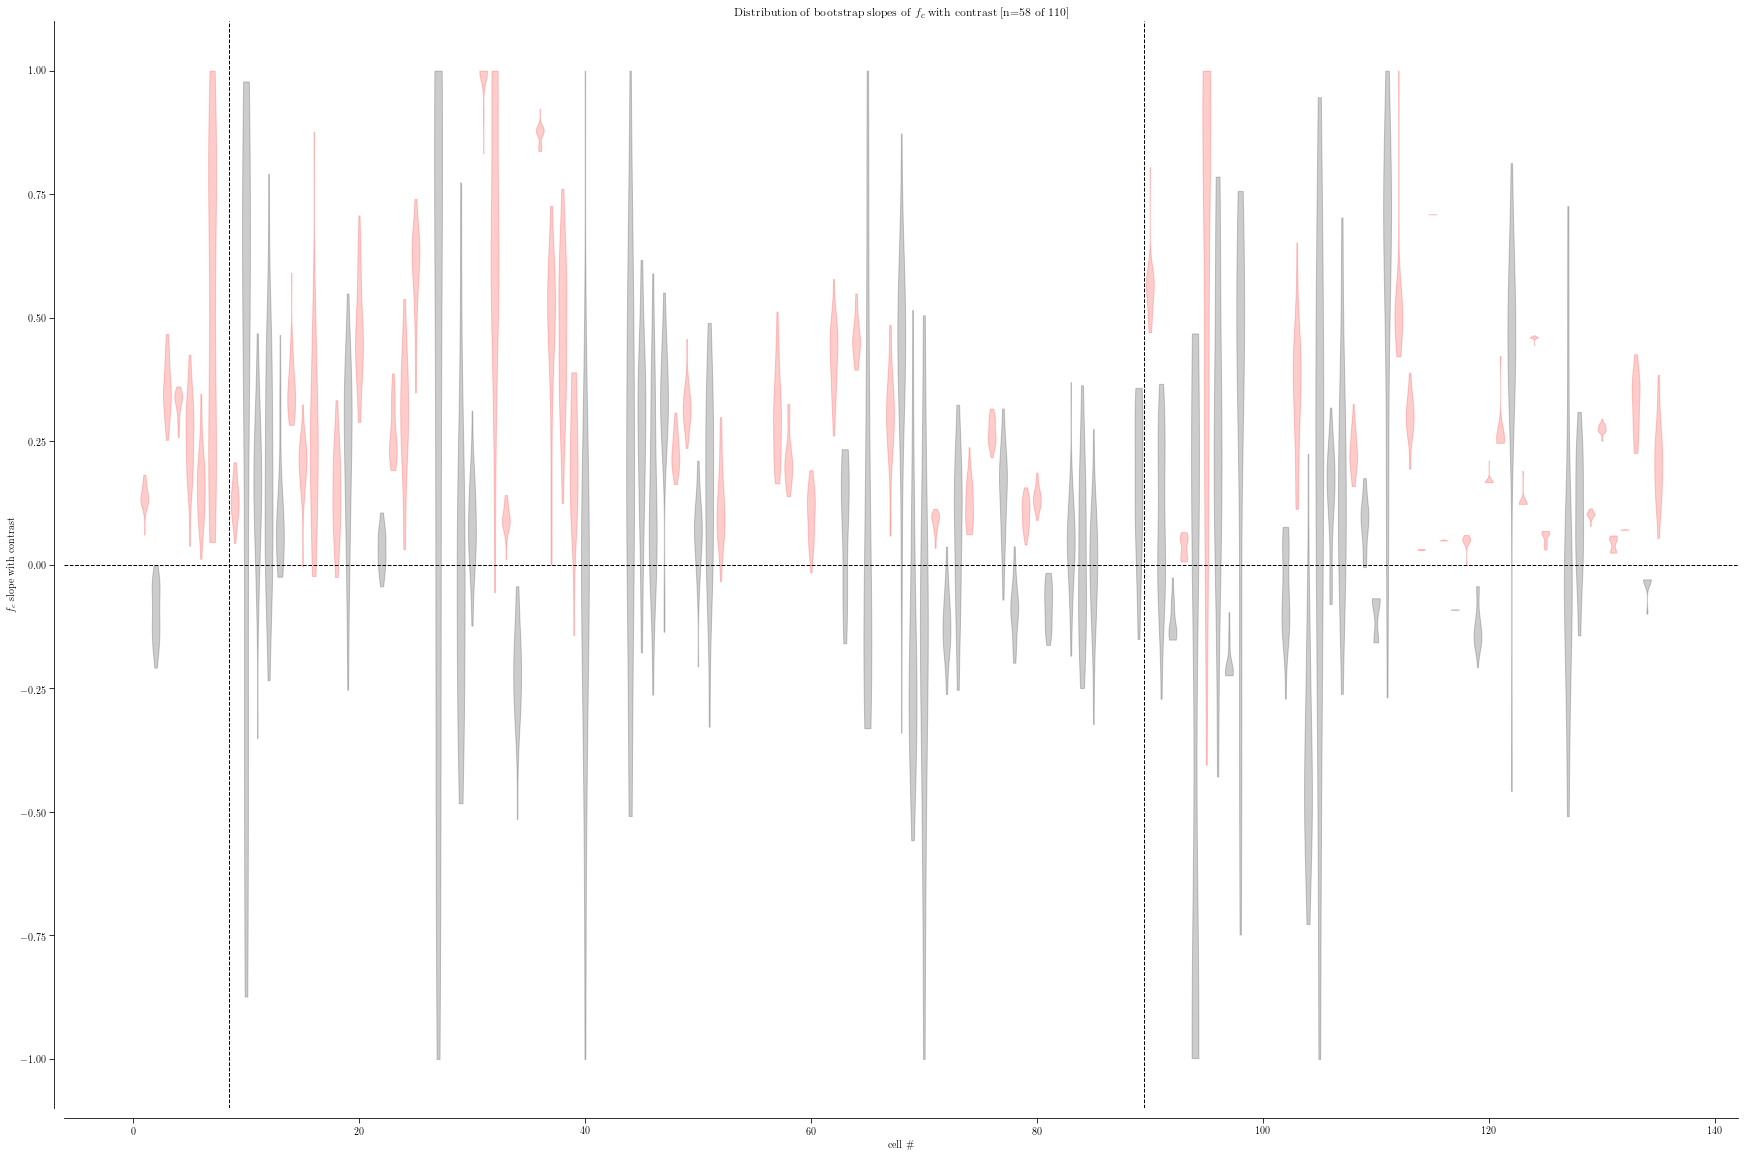

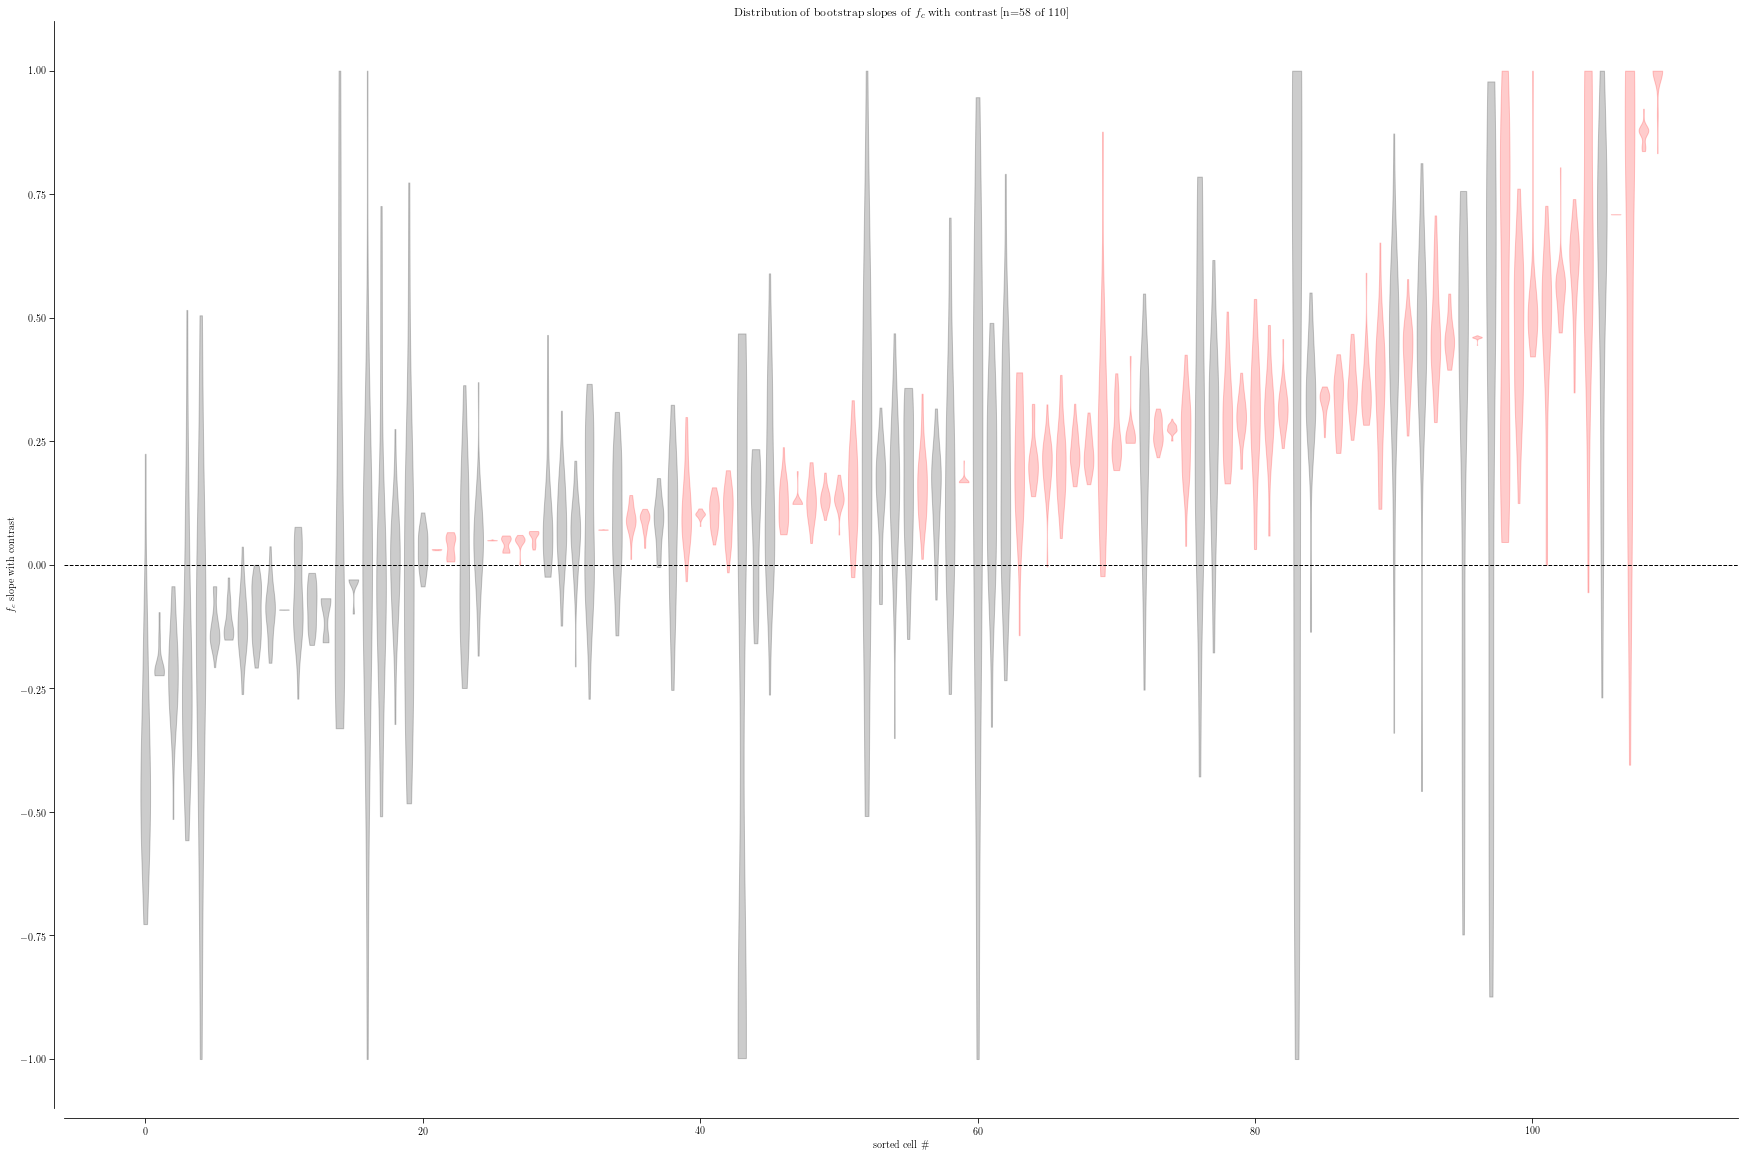

In [1686]:
for to_sort in [0, 1]:

    sort_suffix = '_sorted' if to_sort else ''
    sort_label = 'sorted ' if to_sort else '';

    if not to_sort: # only create/update this if we aren't sorting...
        sig_cells = np.zeros((len(jointList.keys()), ), dtype=np.bool_); 

    non_nan = np.where(~np.isnan(reg_slopes_boot[:,1]))[0]
    sort_by_median = np.argsort(reg_slopes_boot[non_nan,1]);

    if whichArea == 'LGN':
        for ky in jointList.keys():
            # assumes all keys are ordered
            if 'sach' in jointList[ky]['metadata']['fullPath']:
                sach_start = ky; 
                break;
    else: # find the breaks in experiment type
        prevPath = None; newPaths = [];
        for ky in jointList.keys():
            # assumes all keys are ordered
            if prevPath is None:
                prevPath = jointList[ky]['metadata']['fullPath'];
            if prevPath != jointList[ky]['metadata']['fullPath']:
                prevPath = jointList[ky]['metadata']['fullPath'];
                newPaths.append(ky);

    if to_sort:
        rgba_vals = [reg_slopes_boot_all[non_nan[x]] for x in sort_by_median];
        ci_vals = reg_slopes_boot[non_nan[sort_by_median]];
    else:
        rgba_vals = [reg_slopes_boot_all[x] for x in non_nan];
        ci_vals = reg_slopes_boot[non_nan];

    plt.figure(figsize=(30, 20))

    gt0_count = 0;

    if not to_sort and whichArea !='LGN':
        [plt.axvline(j+0.5, color='k', linestyle='--', linewidth=1) for j in newPaths]
    
    for (i, vals), ci in zip(enumerate(rgba_vals), ci_vals):

        pos_curr = i if to_sort else 1+keysAsInts[non_nan[i]];
        viol = plt.violinplot(dataset=vals, positions=[pos_curr], showextrema=False, widths=0.7);

        if not to_sort and i == sach_start and whichArea=='LGN':
            plt.axvline(i+0.5, color='k', linestyle='--', linewidth=1)
#         if not to_sort and whichArea=='V1':
#             if i in newPaths:
#                 plt.axvline(i+0.5, color='k', linestyle='--', linewidth=1)

        # make all the violin stuff black and transparent
        for vp in viol['bodies']:
            is_gt0 = np.sum(np.array(vals)<0)/len(vals) <= .05 # are less than 5% of slopes less than 0?
#             is_gt0 = ci[0] > 0; # is even the 95% lower bound above 0?
            if is_gt0 and not to_sort:
                sig_cells[non_nan[i]] = True;
            clr = 'red' if is_gt0 else 'black';
            gt0_count += is_gt0
    #         plt.text(i, reg_slopes_boot[i,2], s='%02d' )
            vp.set_color(clr)
            vp.set_alpha(0.2);

    plt.axhline(0, color='k', linestyle='--', linewidth=1);
    sns.despine(offset=10)

    plt.xlabel('%scell \#' % sort_label);
    plt.ylabel(r'$f_c$ slope with contrast');
    plt.title(r'Distribution of bootstrap slopes of $f_c$ with contrast [n=%d of %d]' % (gt0_count, len(ci_vals)))

    # now save
    saveName = '02_00_%scFreq_bootSlopes%s.pdf' % (dog_suffix, sort_suffix)
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

#### Quick look into the significant cells

In [1687]:
verbose = 1; # print cell slopes here?

mega['is_sig'] = sig_cells
mega['boot_slope_median'] = reg_slopes_boot_summary[:,0];
mega['boot_slope_mean'] = reg_slopes_boot_summary[:,1];
mega['boot_slope_std'] = reg_slopes_boot_summary[:,2];
# grouped = mega.groupby('is_sig')

f = open('%s02_00_%scFreq_slope_summary.txt' % (save_loc, dog_suffix), "w")

type_key = 'cellType' if whichArea == 'LGN' else 'simple';

# what percentage of m/p are significant?
grouped = mega.groupby(type_key)
f.write('***Significance by type***\n')
print('***Significance by type***')
for name, group in grouped:
    f.write('%.2f%% of %s have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name))
    print('%.2f%% of %s have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name))
    
# what percentage of mine/sach are significant?
grouped = mega.groupby('fullPath')
f.write('\n***Significance by era of experiment***\n')
print('\n***Significance by era of experiment***')
for name, group in grouped:
    f.write('%.2f%% of %s have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name.split('/')[-3]))
    print('%.2f%% of %s have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name.split('/')[-3]))
    
# what percentage of mine/sach are significant?
grouped = mega.groupby('mInd')
f.write('\n***Significance by exp #***\n')
print('\n***Significance by exp #***')
for name, group in grouped:
    f.write('%.2f%% of m%s (%02d of %02d) have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name, np.sum(group['is_sig']), len(group['is_sig'])))
    print('%.2f%% of m%s (%02d of %02d) have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name, np.sum(group['is_sig']), len(group['is_sig'])))
    
# what percentage by mine/sach AND cell type are significant
f.write('\n***Significance, median slope by exp AND %s #***\n' % type_key)
print('\n***Significance, median slope by exp AND %s #***' % type_key)
for name,group in mega.groupby(['fullPath', type_key]):
    nm = name[0].split('/')[-3];
    n_sig = np.sum(group['is_sig'])
    n_tot = len(group['is_sig']);
    mdn_slope = np.nanmedian(group['conSlope_dog_charFreq'])
    print('%s --> %s: %02d of %02d (%.2f%%) --> mdn slope %.2f' % (nm, name[1], n_sig, n_tot, 100*n_sig/n_tot, mdn_slope))
    f.write('%s --> %s: %02d of %02d (%.2f%%) --> mdn slope %.2f\n' % (nm, name[1], n_sig, n_tot, 100*n_sig/n_tot, mdn_slope))
    
f.close()

### --- also print out every slope value (best for diagnostic purposes)
f = open('%s02_00_%scFreq_slope_values.txt' % (save_loc, dog_suffix), "w")
if verbose:
    print('\n\nAll slope values')
f.write('\n\nAll slope values\n')
if whichArea == 'LGN':
    if verbose:
        [print('%02d [%s]: %.2f%s' % (mega['cellNum'][i], typ, x, '*' if sg else '')) for (i, x), sg, typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['cellType'])]
    [f.write('%02d [%s]: %.2f%s\n' % (mega['cellNum'][i], typ, x, '*' if sg else '')) for (i, x), sg, typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['cellType'])]
else:
    expDirs = [x.split('/')[-3] for x in mega['fullPath']]
    if verbose:
        [print('%02d [%s, %s]: %.2f%s' % (mega['cellNum'][i], typ, smp, x, '*' if sg else '')) for (i, x), sg, smp,typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['simple'], expDirs)]
    [f.write('%02d [%s, %s]: %.2f%s\n' % (mega['cellNum'][i], typ, smp, x, '*' if sg else '')) for (i, x), sg, smp,typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['simple'], expDirs)]
f.close()

***Significance by type***
48.44% of complex have significant shifts/slopes
58.70% of simple have significant shifts/slopes

***Significance by era of experiment***
49.18% of V1 have significant shifts/slopes
52.38% of V1_BB have significant shifts/slopes
85.71% of altExp have significant shifts/slopes

***Significance by exp #***
83.33% of m670 (05 of 06) have significant shifts/slopes
100.00% of m671 (01 of 01) have significant shifts/slopes
55.56% of m676 (05 of 09) have significant shifts/slopes
60.00% of m678 (09 of 15) have significant shifts/slopes
43.24% of m681 (16 of 37) have significant shifts/slopes
29.41% of m684 (05 of 17) have significant shifts/slopes
68.00% of m685 (17 of 25) have significant shifts/slopes

***Significance, median slope by exp AND simple #***
V1 --> complex: 22 of 43 (51.16%) --> mdn slope 0.19
V1 --> simple: 08 of 18 (44.44%) --> mdn slope 0.21
V1_BB --> complex: 07 of 19 (36.84%) --> mdn slope 0.19
V1_BB --> simple: 15 of 23 (65.22%) --> mdn slope 0.

In [1688]:
# print('***Proportion of significant cells split by experiment, cell type***\n')
# print(mega.groupby(['fullPath', 'cellType'])['is_sig'].value_counts(normalize=True))
# print('------------\n------------')
# print('***Mean slope, split by experiment, cell type***\n')
# print(mega.groupby(['fullPath', 'cellType'])['conSlope_dog_charFreq'].mean())

##### Let's also validate the model of assuming linear shift on log-log coordinates
i.e. are the errors normally distributed across contrast?

In [1689]:
if jointType < 7: # then we can evaluate this, since the f_c were not determined from a slope model, already


    plt.figure(figsize=hf.set_size(tex_width))
    [plt.scatter(x,y, color='k', alpha=0.3) for x,y in zip(reg_slopes_cons, reg_slopes_errs)];
    # --- and fit a 1d poly to it?
    all_cons_flat = np.hstack(reg_slopes_cons.flatten())
    all_errs_flat = np.hstack(reg_slopes_errs.flatten())
    no_nan = np.logical_and(~np.isnan(all_errs_flat), ~np.isnan(all_cons_flat))
    all_errs_flat = all_errs_flat[no_nan]
    all_cons_flat = all_cons_flat[no_nan]
    fine = opt.curve_fit(fn, np.log10(all_cons_flat), all_errs_flat)
    pmz = fine[0];
    cons_to_plot = np.geomspace(np.min(all_cons_flat), np.max(all_cons_flat), 100);
    plt.semilogx(cons_to_plot, fn(np.log10(cons_to_plot), *pmz), 'r--', linewidth=1, label='%.2e+x*%.2e' % (*pmz, ))
    plt.xscale('log');
    plt.xlabel('Contrast');
    plt.legend();
    plt.ylabel('Error of fit to slope of $f_c$');
    plt.title('Distribution of errors by contrast')
    sns.despine(offset=sns_offset)
    
    # now save
    saveName = '02_00c_%scFreq_errors.pdf' % (dog_suffix)
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()
        
    # group into bins, see if 
    # -- (a) error is significantly different from 0
    # -- (b) distribution is lopsided above/below zero
    nBins = 10;
    _, bin_edges = np.histogram(np.log10(all_cons_flat), bins=nBins)
    indz = np.digitize(np.log10(all_cons_flat), bin_edges[1:-1], right=False);
    for ii, ind in enumerate(np.unique(indz)):
        distr = all_errs_flat[np.where(indz==ii)];
        
        if distr.size==0:
            continue;
        
        distr_mean, distr_std = np.mean(distr), np.std(distr)
        distr_rescale = (distr-distr_mean)/distr_std;
        wilcox_pval = ss.wilcoxon(distr).pvalue;
        ks_pval = ss.ks_1samp(distr_rescale, ss.norm.cdf).pvalue;
        tt_pval = ss.ttest_1samp(distr, popmean=0).pvalue; 
        print('[con: %03d-%03d] mean(std) = %.03f(%.02f) --> symmetric errs{wilcoxon}||isGauss{k-s test}: p = %.3f||%.3f [n=%03d]' % (100*np.power(10, bin_edges[ii]), 100*np.power(10, bin_edges[ii+1]), 
                                                                                                            distr_mean, distr_std, 
                                                                                                            wilcox_pval, 
                                                                                                            ks_pval, len(distr)))
        plt.figure(figsize=hf.set_size(tex_width));
        plt.plot(sorted(distr), 'k-', label='orig (wilcox=%.3f; tt=%.3f)' % (wilcox_pval, tt_pval));
        plt.plot(sorted(distr_rescale), 'k--', label='z-scored [ks pval=%.3f]' % (ks_pval));
        samps = np.random.randn(len(distr_rescale));
        plt.plot(sorted(samps), 'r--', label='norm.');
        plt.legend();
        plt.xlabel('sorted sample \#')
        plt.ylabel('error');
        plt.title('Distribution of errors for contrasts between %03d%%-%03d%%' % (100*np.power(10, bin_edges[ii]), 100*np.power(10, bin_edges[ii+1])))
        saveName = '02_00d_%scFreq_errorsDistr_bin%02d.pdf' % (dog_suffix, ii)
        pdfSv = pltSave.PdfPages(save_loc + saveName);
        f = plt.gcf()
        pdfSv.savefig(f) # only one figure here...
        pdfSv.close()
        plt.close(f)

In [1690]:
if jointType < 7:

    ok_comps = np.where([np.all(~np.isnan(x)) for x in reg_slopes_errs])[0];

    pvs = np.array([ss.ks_1samp(ss.zscore(errs), ss.norm.cdf).pvalue for errs in reg_slopes_errs[ok_comps]])
    print('%02d of %02d errors are not normally distributed after z-scoring' % (np.sum(pvs<0.05), len(pvs)))
    pvs = np.array([ss.ttest_1samp(errs, 0).pvalue for errs in reg_slopes_errs[ok_comps]])
    print('%02d of %02d errors have non-zero mean (ttest)' % (np.sum(pvs<0.05), len(pvs)))

##### Plot the regression slopes we fit above

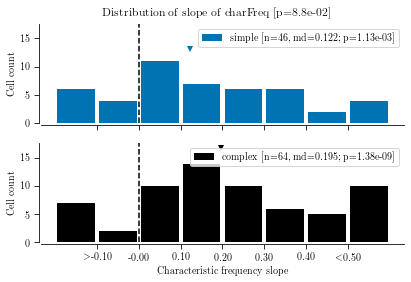

In [1691]:
use_norm = False;
wider_bins = False;
shift_bins = True

# applies only if LGN
skip_other = True;

norm_str = '_normed' if use_norm else '';
wider_str = '_wider' if wider_bins else '';
shift_str = '_shift' if shift_bins else '';
skip_str = '_skipOther' if skip_other and whichArea=='LGN' else ''
metr = 'charFreq'

saveName = '02_01_%s%s%s%s%s%s_slopes.pdf' % (dog_suffix, metr, norm_str, wider_str, shift_str, skip_str)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

nrow=len(grp_names) if whichArea=='V1' else len(grp_names)-skip_other;
f, ax = plt.subplots(nrows=nrow, ncols=1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
                    sharex=True, sharey=True)

grouped = mega.groupby(toGroup, sort=srt_group)

# gather and calculate
if wider_bins:
    bins = np.linspace(-0.3, 0.7, 9) if shift_bins else np.linspace(-0.5, 0.5, 9);
else:
    bins = np.linspace(-0.2, 0.6, 9) if shift_bins else np.linspace(-0.4, 0.4, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = hist_width*stepSize;

metr_nice = 'Characteristic frequency' if metr == 'charFreq' else metr;

for (i, (name, group)), clr in zip(enumerate(grouped), colors):
    
    if skip_other: # even if True when V1, the below won't matter!
        if name=='other':
            continue;
    
    vals_no_nan = hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)])
    
    clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(vals_no_nan);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    to_use = vals_norm if use_norm else vals;
    
    ax[i].plot(mdn, 1.2*np.max(to_use), 'v', color=clr)
    
    pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
    ax[i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.3f; p=%.2e]' % (name, np.sum(vals), mdn, pval_curr.pvalue), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    ax[i].set_xticks(tickVals);
    ax[i].set_xticklabels(tickStrs);
    
    # unity/no effect line
    ax[i].axvline(no_effect, color='k', linestyle='--')
    ax[i].legend()
    ax[i].set_ylabel('Proportion of Cells' if use_norm else 'Cell count');
    if i == nrow-1:
        ax[i].set_xlabel(r'%s slope' % metr_nice);

    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)]))
    else:
        to_comp.append(hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)]))
    
ttest = ss.ttest_ind(*to_comp);
f.suptitle(r'Distribution of slope of %s [p=%.1e]' % (metr, ttest.pvalue), y=hist_ytitle)

sns.despine(offset=sns_offset);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### Let's also plot the slope size vs. variability --- let's make sure that it's not just high variability conditions with large slopes!

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


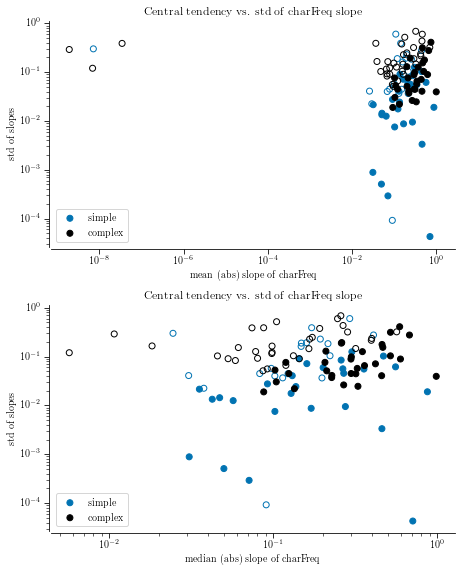

In [1692]:
which_metr = 1; # 0 for median, 1 for mean

fold = 1; # fold negative slopes to positive?
fold_str = '(abs) ' if fold else '';

saveName = '02_01var_%s%s_slopes.pdf' % (dog_suffix, metr)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

f, ax = plt.subplots(2, 1, figsize=hf.set_size(tex_width, subplots=(2,1)));

grouped = mega.groupby(toGroup, sort=srt_group)

for i,summary in enumerate(['mean', 'median']):

    for (name, group), clr in zip(grouped, colors):
        
        sig_clr = [clr if x else 'None' for x in group['is_sig']];
        
        if i==1:
            vals = np.abs(group['boot_slope_mean']) if fold else group['boot_slope_mean']
        elif i==0:
            vals = np.abs(group['boot_slope_median']) if fold else group['boot_slope_median']
            
        ax[i].scatter(vals, group['boot_slope_std'], label='%s' % name, color=sig_clr, edgecolor=clr)
        
    # unity/no effect line
    ax[i].axvline(no_effect, color='k', linestyle='--', alpha=0.3)
    if fold:
        ax[i].set_xscale('log');
        ax[i].set_yscale('log');
    else:
        ax[i].set_xscale('symlog', linthreshx=0.1)
    ax[i].set_xlabel(r'%s %sslope of %s' % (summary,fold_str,metr));
    ax[i].set_ylabel('std of slopes');
    ax[i].set_title(r'Central tendency vs. std of %s slope' % (metr))
    ax[i].legend()

sns.despine(offset=sns_offset);
f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 02. Scatter plots!

#### 02.02a sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

In [1693]:
# whichFit = 1; # 0 for non-DoG, 1 for DoG
# excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
# exclStr = '_excl33' if excludeOneThirds else ''
# normCon = 0; # normalize by the contrast ratio ()

# # are we getting the values from the bootstrap estimates or no?
# bootEst = 1;
# bootStr= '_boot' if bootEst else '';

# normStr = '_norm' if normCon else ''

# prefix = 'dog_' if whichFit==1 else ''
# suffix = '[DoG] ' if whichFit==1 else ''

# saveName = '02_02a_sf70_%sscatter_%s%s%s.pdf' % (prefix, fitBase, exclStr, bootStr);

# nrow, ncol = 1,2
# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

# # Likely unchanged...
# low, ctr, high = 25, 50, 75; # get median, and bounds for X% C.I. (e.g. 95%)
# disp=0 
# yLabels = ['33% contrast', 'lowest valid contrast']
# alphScatter = 0.5

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for i,ylbl in enumerate(yLabels):
    
#     to_comp = [];
    
#     ### Gather the data, put into "mega"
#     if bootEst:
#         highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % prefix, whichFit, i)
#         highSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in highSf])
#         compSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in compSf])

#         if i == 0:
#             mega['%ssf70_high' % prefix] = highSplits[:,0];
#             mega['%ssf70_high_CI_lo' % prefix] = highSplits[:,1];
#             mega['%ssf70_high_CI_hi' % prefix] = highSplits[:,2];
#             mega['%ssf70_third' % prefix] = compSplits[:,0];
#             mega['%ssf70_third_CI_lo' % prefix] = compSplits[:,1];
#             mega['%ssf70_third_CI_hi' % prefix] = compSplits[:,2];
#             mega['%ssf70_cons_third' % prefix] = compCons;
#         elif i == 1:
#             mega['%ssf70_low' % prefix] = compSplits[:,0];
#             mega['%ssf70_low_CI_lo' % prefix] = compSplits[:,1];
#             mega['%ssf70_low_CI_hi' % prefix] = compSplits[:,2];
#             mega['%ssf70_cons_low' % prefix] = compCons;
        
#     else:
#         highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, i)
#         if i == 0:
#             mega['%ssf70_high' % prefix] = highSf;
#             mega['%ssf70_third' % prefix] = compSf;
#             mega['%ssf70_cons_third' % prefix] = compCons           
#         elif i == 1:
#             mega['%ssf70_low' % prefix] = compSf;
#             mega['%ssf70_cons_low' % prefix] = compCons

#     # and add ratio
#     highSfs = mega['%ssf70_high' % prefix]
#     divFactor = np.log2(np.divide(1, compCons)) if normCon else 1;
#     if i == 0:
#         mega['%ssf70_ratio_third%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_third' % prefix])) / divFactor
#     elif i == 1:
#         mega['%ssf70_ratio_low%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_low' % prefix])) / divFactor

            
#     ### Go through by group to plot
#     grouped = mega.groupby(toGroup, sort=srt_group)
    
#     for (name, group), clr in zip(grouped, colors):
    
#         compCons = group['%ssf70_cons_third' % prefix] if i == 0 else group['%ssf70_cons_low' % prefix];
#         if excludeOneThirds and i == 1:
#             validInds = compCons<0.3 #np.where(compCons<0.3)[0];
#         else:
#             validInds = compCons<0.4 #np.where(compCons<0.4)[0]; # should be at least <40% contrast!

#         highSf = group['%ssf70_high' % (prefix)]
#         compSf = group['%ssf70_third' % (prefix)] if i==0 else group['%ssf70_low' % prefix]
            
#         if bootEst:
#             hi_errLow = group['%ssf70_high_CI_lo' % prefix] if i == 0 else group['%ssf70_high_CI_lo' % prefix]
#             hi_errHigh = group['%ssf70_high_CI_hi' % prefix] if i == 0 else group['%ssf70_high_CI_hi' % prefix]
#             comp_errLow = group['%ssf70_third_CI_lo' % prefix] if i == 0 else group['%ssf70_low_CI_lo' % prefix]
#             comp_errHigh = group['%ssf70_third_CI_hi' % prefix] if i == 0 else group['%ssf70_low_CI_hi' % prefix]
            
#         non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
#         val_inds = np.logical_and(non_nan, validInds)
        
#         rats_curr = np.divide(highSf[val_inds], compSf[val_inds]);
#         if normCon:
#             conRat_log2 = np.log2(np.divide(1, compCons[val_inds]))
#             rats_curr = np.divide(rats_curr, conRat_log2);

#         paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
#         pval = paired_t.pvalue;
        
#         if bootEst: # then we include C.I.!
#             ax[i].errorbar(highSf[val_inds], compSf[val_inds], 
#                            xerr=[hi_errLow[val_inds] - highSf[val_inds], highSf[val_inds] - hi_errHigh[val_inds]],
#                            yerr=[comp_errLow[val_inds] - compSf[val_inds], compSf[val_inds] - comp_errHigh[val_inds]],
#                            label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval), 
#                            alpha=alphScatter, color=clr, fmt='o')#, s=30)
#         else:
#             ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=alphScatter, color=clr, 
#                           s=30, label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval))
            
#         if len(grouped) > 2: # i.e. it's LGN...
#             if name == 'other':
#                 continue;
#             to_comp.append(rats_curr)
#         else:
#             to_comp.append(rats_curr)

#     # after plotting each group, set the visuals        
#     ax[i].loglog([0.3,15], [0.3, 15], 'k--')
#     paired_t = ss.ttest_ind(to_comp[0], to_comp[1])
#     pval = paired_t.pvalue;
#     ax[i].set_title('High f cut-off (70%% of peak) w/con %s(p=%.2e)' % (suffix, pval))
#     ax[i].set_xlabel('High contrast')
#     ax[i].set_ylabel(ylbl)
#     ax[i].set_aspect('equal')
#     ax[i].legend()
    
# sns.despine(offset=sns_offset)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [1694]:
# # Then, the histogram
# saveName = saveName.replace('scatter', 'hist%s' % normStr)

# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

# if normCon:
#     bins = np.linspace(-0.5, 0.5, 9);
# else:
#     bins = np.linspace(-1.25, 1.25, 11);
# stepSize = (bins[-1] - bins[0])/(len(bins)-1);
# binPlotLocs = bins[1:] - 0.5*stepSize;
# tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

# width = hist_width*stepSize

# normStr = ', con. norm' if normCon==1 else '';

# xlabs = ['1:0.33', '1:lowestCon']

# grouped = mega.groupby(toGroup, sort=srt_group)

# no_effect = 0;

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for (i,ylbl), xlab in zip(enumerate(yLabels), xlabs):

#     #########################
#     for (name, group), clr in zip(grouped, colors):
    
#         key_str = '%ssf70_ratio_third%s' % (prefix, bootStr) if i == 0 else '%ssf70_ratio_low%s' % (prefix, bootStr)
#         vals_no_nan = hf.nan_rm(group[key_str]); # log transform the ratios s.t. 0 means no shift

#         ratsClipped = np.clip(vals_no_nan, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
#         vals, _ = np.histogram(ratsClipped, bins=bins)
#         vals_norm = vals/np.sum(vals)

#         # compute mean/median, pvalue (i.e. are ratios diff. from 0)
#         mn, mdn = np.nanmean(vals_no_nan), np.nanmedian(vals_no_nan);
#         pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
       
        
#         # plot the median, add label
#         ax[i].plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15, 
#                    label='%s [n=%02d, mdn=%.1e; p=%.1e]' % (name, len(ratsClipped), mdn,  pval_curr.pvalue))

#         # plot the histogram
#         ax[i].bar(binPlotLocs, vals_norm, width=width, align='center', color=clr,
#                 alpha=alphHist);
        
#         # do the ticks
#         tickStrs = ['%.2f' % x for x in tickVals];
# #         tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
#         tickStrs[0] = '<%s' % tickStrs[0];
#         tickStrs[-1] = '>%s' % tickStrs[-1];
#         ax[i].set_xticks(tickVals);
#         ax[i].set_xticklabels(tickStrs)
        
#         # add a no-effect line, legend, axis labels, etc
#         ax[i].axvline(0, linestyle='--', color='k')
#         ax[i].legend(fontsize='x-small');
#         ax[i].set_xlabel(r'(log2%s) ratio of $sf_{70}$ change' % normStr)
#         ax[i].set_ylabel('Proportion of cells');
        
        
# sns.despine(offset=sns_offset)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

##### A look at suppression index vs. slope

Two subplots -- left side, colored by significance or not; right side, colored by cell type

In [1697]:
ok_inds = np.logical_and(~np.isnan(suprs), ~np.isnan(slopes))
# ok_inds = np.logical_and(~np.isnan(suprs[sigs]), ~np.isnan(slopes[sigs]))

In [1698]:
# np.corrcoef(suprs[sigs][ok_inds], slopes[sigs][ok_inds])
np.corrcoef(suprs[ok_inds], slopes[ok_inds])

array([[ 1.        , -0.06727161],
       [-0.06727161,  1.        ]])

supr. index for all sig. cells: 0.46
supr. index for all NOT sig. cells: 0.46
pval for t-test between sig + non-sig supr. index: 0.98
supr. index mean of 0.51 for complex
supr. index mean of 0.39 for simple


char freq. mean of 4.37 for complex
char freq. mean of 2.48 for simple


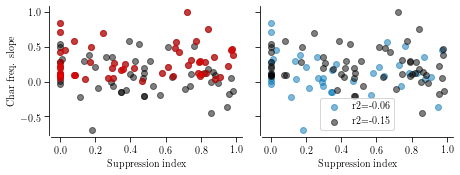

In [1700]:
x = 'complex' # comparison; adjust per experiment...
supr_ind_mod = True; # model or data-derived suppression index?
supr_str = 'model' if supr_ind_mod else 'data'

saveName = '02_03_suprInd_%s_vs_slope.pdf' % supr_str;

nrows,ncols=1,2; #
f, ax = plt.subplots(nrows,ncols, figsize=hf.set_size(tex_width, subplots=(nrows,ncols), extra_height=1.25), sharex=True, sharey=True);

if jointType >= 7:

    slp_key = 'dog_mod';
    slopes = -mega['%s_slope' % slp_key]
    suprs = mega['rfsize.suprInd_%s' % (supr_str)]
    sigs = mega['is_sig']
    cell_type = mega['triType'] if whichArea=='LGN' else mega['simple']
    cfs = np.array([mega['dog_charFreq'][x][0,-1] for x in range(len(mega))])
    
    # mean of suppression index for all sig. cells
    print('supr. index for all sig. cells: %.2f' % np.nanmean(suprs[sigs]));
    
    # mean of suppression index for all NON sig. cells
    print('supr. index for all NOT sig. cells: %.2f' % np.nanmean(suprs[~sigs]));
    
    tt = ss.ttest_ind(hf.nan_rm(suprs[sigs]), hf.nan_rm(suprs[~sigs]));
    print('pval for t-test between sig + non-sig supr. index: %.2f' % tt.pvalue)
    
    [print('supr. index mean of %.2f for %s' % (np.nanmean(suprs[cell_type==x]), x)) for x in np.unique(cell_type)]
    print('\n')
    [print('char freq. mean of %.2f for %s' % (np.nanmean(cfs[cell_type==x]), x)) for x in np.unique(cell_type)]
    
    ss.ttest_ind(hf.nan_rm(cfs[np.logical_and(sigs, cell_type==x)]), hf.nan_rm(cfs[np.logical_and(~sigs, cell_type==x)]))
    
    # first, sig. vs. not sig 
    ax[0].scatter(suprs,slopes,color='k',alpha=0.5)#, clip_on=False);
    
    ax[0].scatter(suprs[sigs],slopes[sigs],color='r',alpha=0.5)
    # plt.xscale('symlog', linthresh=0.1);
    ax[0].set_xlabel('Suppression index')
    ax[0].set_ylabel('Char freq. slope')

    # then, plot by cell type 
    grouped = mega.groupby(toGroup, sort=srt_group)

    for (name, group), clr in zip(grouped, colors):

        ok_inds = np.logical_and(~np.isnan(group['rfsize.suprInd_%s' % (supr_str)]), ~np.isnan(group['%s_slope' % slp_key]));
        corr = np.corrcoef(group['rfsize.suprInd_%s' % (supr_str)][ok_inds], -group['%s_slope' % slp_key][ok_inds])[0,-1]
        
        ax[1].scatter(group['rfsize.suprInd_%s' % (supr_str)], -group['%s_slope' % slp_key], color=clr,alpha=0.5,label='r2=%.2f' % corr)
        # plt.xscale('symlog', linthresh=0.1);
        ax[1].set_xlabel('Suppression index')
#         ax[1].set_ylabel('Char freq. slope')
        ax[1].legend();
    
    f.tight_layout();
    sns.despine(offset=sns_offset)
    
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

#### A look at volume ratio with contrast?

## 3. Mechanism (with DoG analysis)

#### Let's get the radius, gain, volume for the center and surround mechanisms

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:190: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:223: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:223: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the s

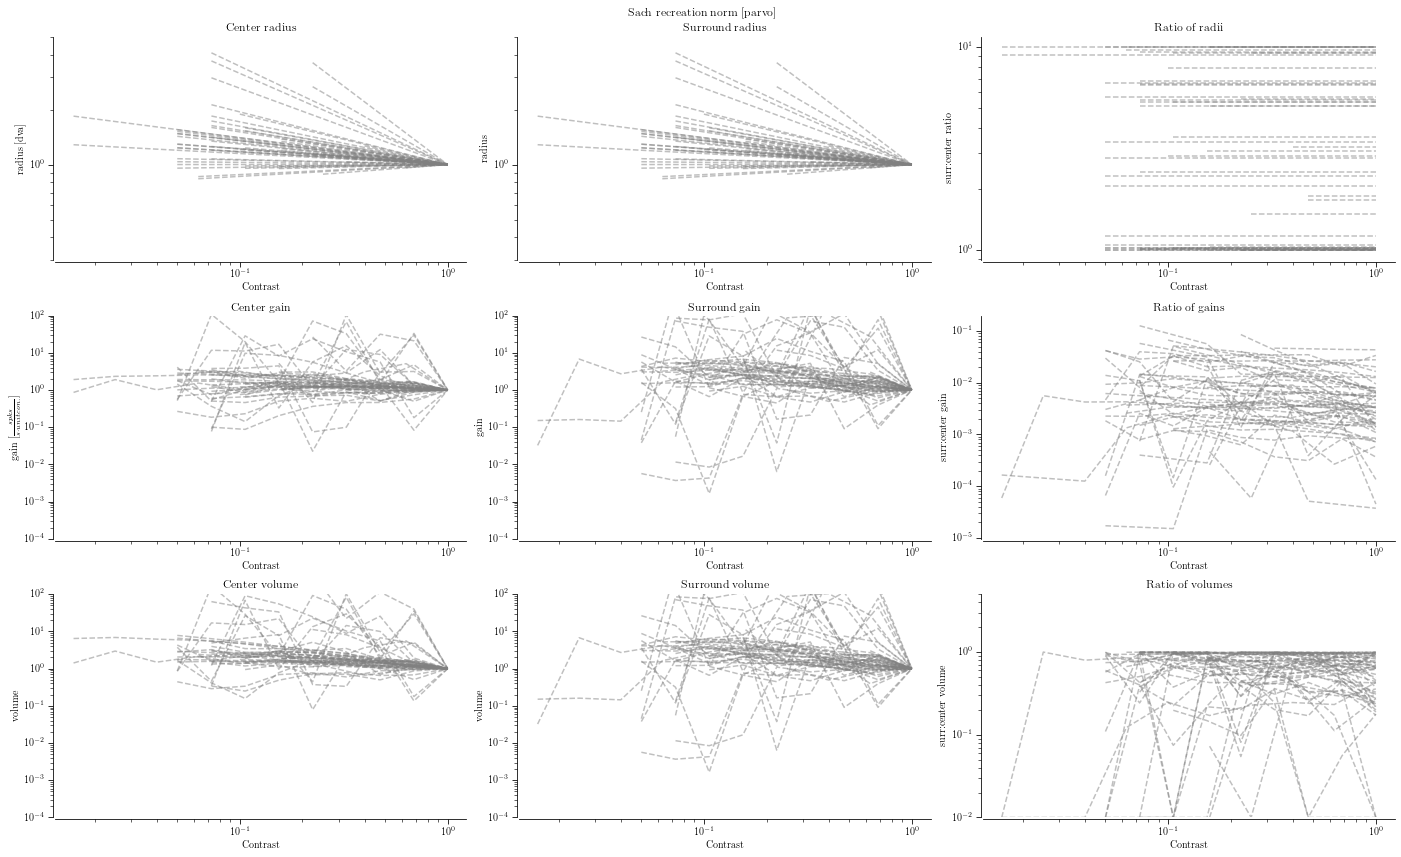

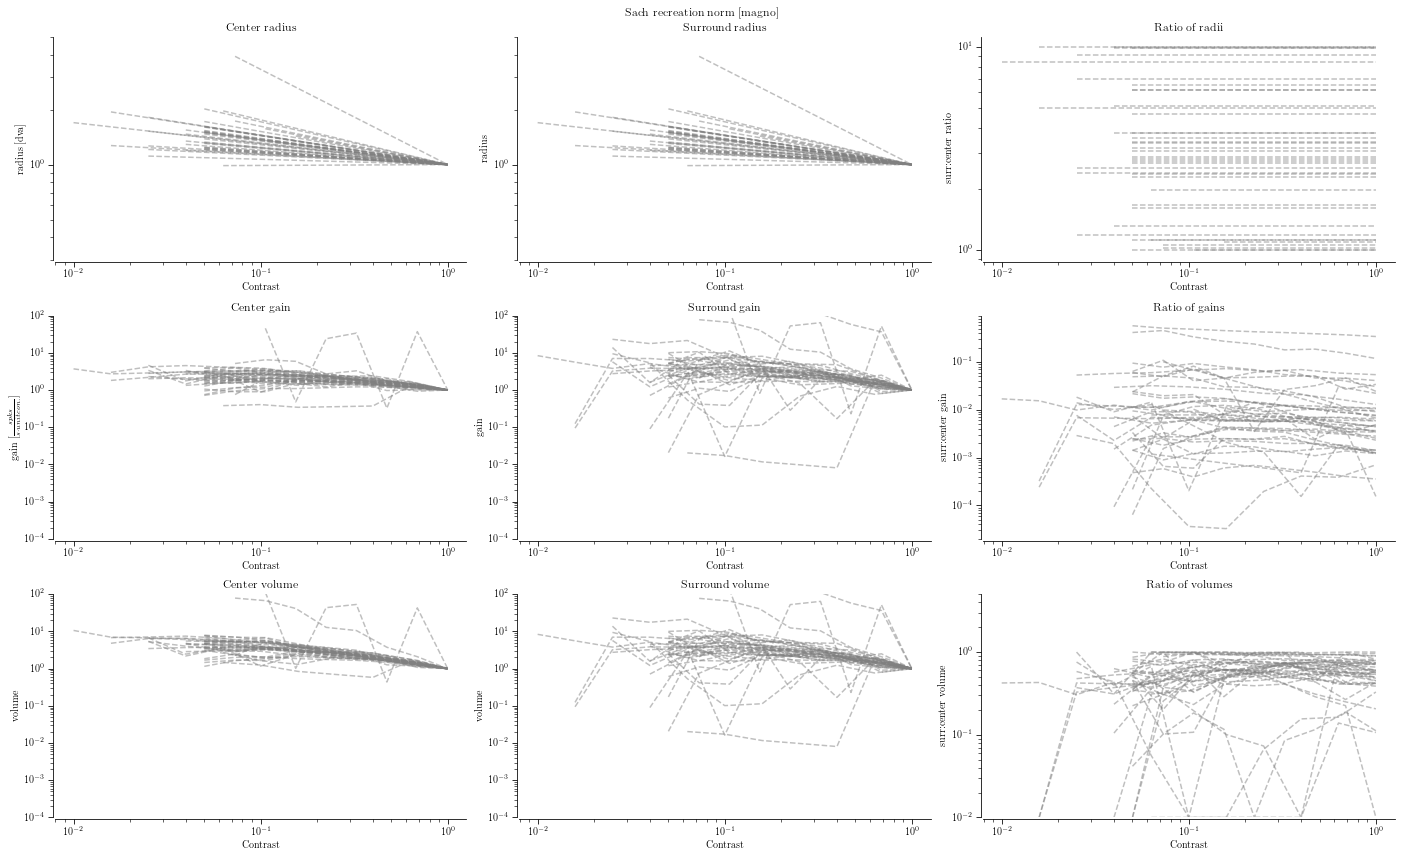

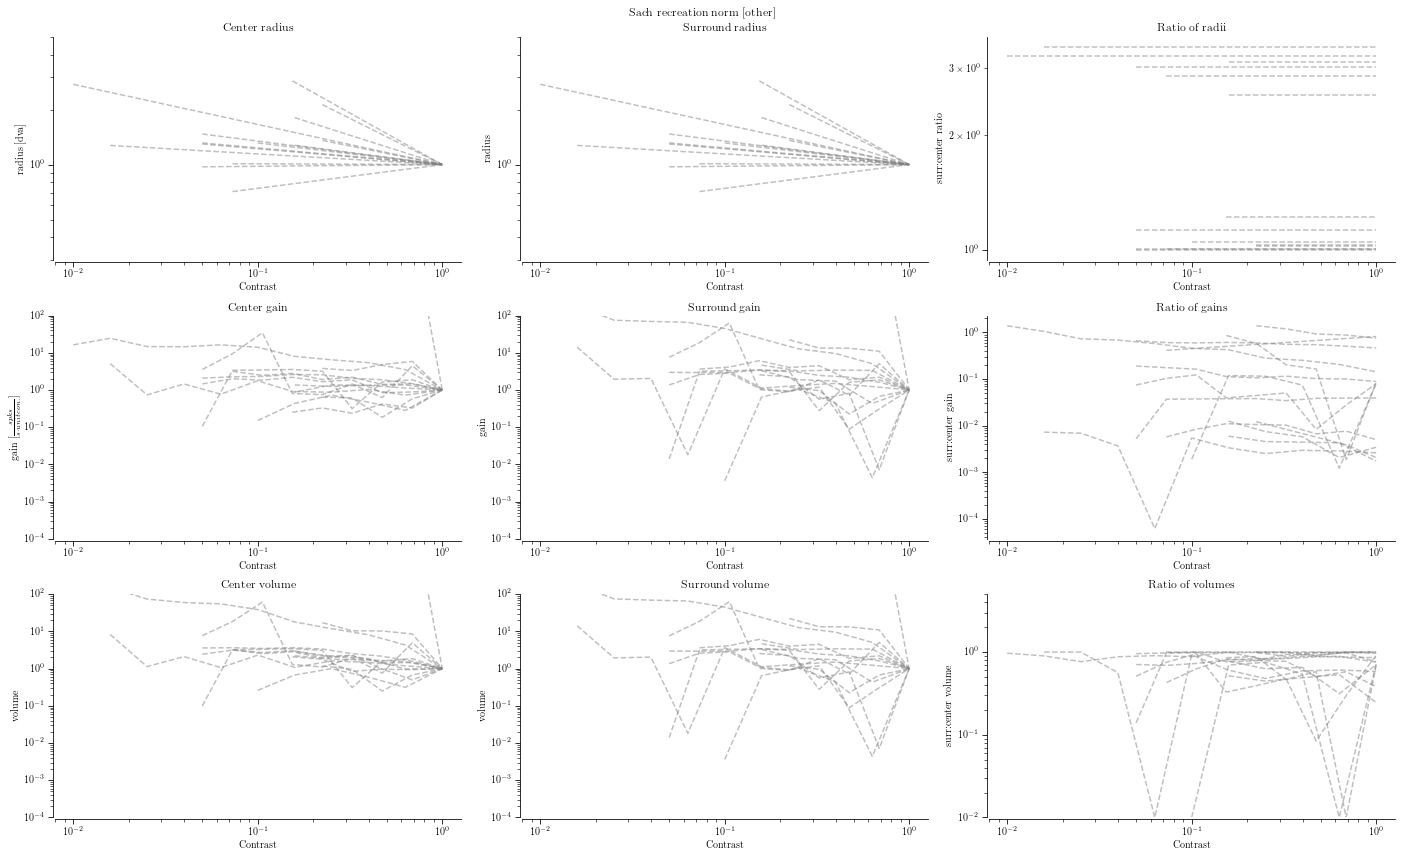

In [1585]:
grouped = mega.groupby(toGroup, sort=srt_group)

boot = 0;
bootStr = 'boot ' if boot else ' ';

disp = 0;
norm = 1;
normStr = 'norm ' if norm else ' ';

# indices into ['dog_mech']
i_gc, i_rc, i_vc, i_gs, i_rs, i_vs = range(6);
mdn = 50; # we want 50th percentile

nrow, ncol = 3, 3;

for (name, group), clr in zip(grouped, colors):

    f, ax = plt.subplots(nrow, ncol, figsize=hf.set_size(tex_width, fraction=nrow, subplots=(nrow,ncol)));

    # do the visuals, axes, labels, etc
    gray = cm.gray(0.5) # mean gray
    f.suptitle('Sach recreation %s[%s]' % (normStr, name))
    f.subplots_adjust(wspace=0.2, hspace=0.25);

    ##########
    #### RADIUS
    ##########
    
    # center radius
    plt.subplot(3, 3, 1);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 1]);
    plt.xlabel('Contrast');
    plt.ylabel(r'radius [dva]')
    plt.title('Center radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround radius
    plt.subplot(3, 3, 2);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('radius')
    plt.title('Surround radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround radius
    plt.subplot(3, 3, 3);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center ratio')
    plt.title('Ratio of radii')
    plt.xscale('log')
    plt.yscale('log')

    ##########
    #### GAIN
    ##########

    # center gain
    plt.subplot(3, 3, 4);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel(r'gain [$\frac{spks}{s \cdot unit con.}$]')
    plt.title('Center gain')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround gain
    plt.subplot(3, 3, 5);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('gain')
    plt.title('Surround gain')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround gain
    plt.subplot(3, 3, 6);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center gain')
    plt.title('Ratio of gains')
    plt.xscale('log')
    plt.yscale('log')
    
    ##########
    #### VOLUME
    ##########
    
    # center volume
    plt.subplot(3, 3, 7);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Center volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround volume
    plt.subplot(3, 3, 8);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Surround volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround volume
    plt.subplot(3, 3, 9);
    if norm:
        plt.ylim([1e-2, 5]);
    else:
        plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center volume')
    plt.title('Ratio of volumes')
    plt.xscale('log')
    plt.yscale('log')
    
    for ky in group['cellType'].index:
        
        # Go through each cell in this group
        curr_dir = group['fullPath'][ky].split('/')[-3]
        curr_num = group['cellNum'][ky];
        curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
        
        # -- get the contrasts that are used
        curr_inds = group['val_con_by_disp'][ky][disp]; # zero dispersion, always?
        curr_cons = group['stimVals'][ky][1][curr_inds]
        
        # center radius
        plt.subplot(3, 3, 1);
        if boot:
            curr_rc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rc, :], mdn, axis=1)
        else:
            curr_rc = group['dog_mech'][ky][disp, curr_inds, i_rc]
        non_nan = np.where(~np.isnan(curr_rc))[0]
        if len(non_nan) > 1:
            curr_rc_plt = np.divide(curr_rc, curr_rc[non_nan[-1]]) if norm else curr_rc;
            plt.plot(curr_cons, curr_rc_plt, '--', color=gray, alpha=0.5)

        # surround radius
        plt.subplot(3, 3, 2);
        if boot:
            curr_rs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rs, :], mdn, axis=1)
        else:
            curr_rs = group['dog_mech'][ky][disp, curr_inds, i_rs]
        non_nan = np.where(~np.isnan(curr_rs))[0]
        if len(non_nan) > 1:
            curr_rs_plt = np.divide(curr_rs, curr_rs[non_nan[-1]]) if norm else curr_rs;
            plt.plot(curr_cons, curr_rs_plt, '--', color=gray, alpha=0.5)
            
        # center:surr radii
        plt.subplot(3, 3, 3);
        curr_rats = np.divide(curr_rs, curr_rc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

        ##########
        #### GAIN
        ##########
    
        # center gain
        plt.subplot(3, 3, 4);
        if boot:
            curr_gc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_gc, :], mdn, axis=1)
        else:
            curr_gc = group['dog_mech'][ky][disp, curr_inds, i_gc]
        non_nan = np.where(~np.isnan(curr_gc))[0]
        if len(non_nan) > 1:
            curr_gc_plt = np.divide(curr_gc, curr_gc[non_nan[-1]]) if norm else curr_gc;
            plt.plot(curr_cons, curr_gc_plt, '--', color=gray, alpha=0.5)

        # surround volume
        plt.subplot(3, 3, 5);
        if boot:
            curr_gs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_gs, :], mdn, axis=1)
        else:
            curr_gs = group['dog_mech'][ky][disp, curr_inds, i_vs]
        non_nan = np.where(~np.isnan(curr_gs))[0]
        if len(non_nan) > 1:
            curr_gs_plt = np.divide(curr_gs, curr_gs[non_nan[-1]]) if norm else curr_gs;
            plt.plot(curr_cons, curr_gs_plt, '--', color=gray, alpha=0.5)

        # volume ratio
        plt.subplot(3, 3, 6);
        curr_rats = np.divide(curr_gs, curr_gc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)
            
        ##########
        #### VOLUME
        ##########
    
        # center volume
        plt.subplot(3, 3, 7);
        if boot:
            curr_vc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vc, :], mdn, axis=1)
        else:
            curr_vc = group['dog_mech'][ky][disp, curr_inds, i_vc]
        non_nan = np.where(~np.isnan(curr_vc))[0]
        if len(non_nan) > 1:
            curr_vc_plt = np.divide(curr_vc, curr_vc[non_nan[-1]]) if norm else curr_vc;
            plt.plot(curr_cons, curr_vc_plt, '--', color=gray, alpha=0.5)

        # surround volume
        plt.subplot(3, 3, 8);
        if boot:
            curr_vs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vs, :], mdn, axis=1)
        else:
            curr_vs = group['dog_mech'][ky][disp, curr_inds, i_vs]
        non_nan = np.where(~np.isnan(curr_vs))[0]
        if len(non_nan) > 1:
            curr_vs_plt = np.divide(curr_vs, curr_vs[non_nan[-1]]) if norm else curr_vs;
            plt.plot(curr_cons, curr_vs_plt, '--', color=gray, alpha=0.5)

        # volume ratio
        plt.subplot(3, 3, 9);
        curr_rats = np.divide(curr_vs, curr_vc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

    # then after all cells, save
    f.tight_layout()
    sns.despine(offset=sns_offset)
    
    saveName = "/03_01_sach_%s%s%s.pdf" % (normStr.replace(' ', '_'), bootStr.replace(' ', '_'), name)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

# END OF UPDATED ANALYSES

#### 02.02b Preferred spatial frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

In [1556]:
# whichFit = 0; # 0 for flexible gauss, 1 for DoG
# excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
# exclStr = '_excl33' if excludeOneThirds else ''

# prefix = 'dog_' if whichFit==1 else ''
# suffix = '[DoG] ' if whichFit==1 else ''

# saveName = '02_02b_sfPref_%sscatter_%s%s.pdf' % (prefix, fitBase, exclStr);

# nrow, ncol = 1,2
# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

# disp=0
# yLabels = ['33% contrast', 'lowest valid contrast']

# rats_both = [];

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for i,ylbl in enumerate(yLabels):

#     highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, i)
    
#     if excludeOneThirds and i == 1:
#         validInds = np.where(compCons<0.3)[0];
#     else:
#         validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
#     non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
#     val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
       
#     rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
        
#     ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
#     ax[i].loglog([0.3,10], [0.3, 10], 'k--')
#     paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
#     pval = paired_t.pvalue;
#     ax[i].set_title('Preferred SF with contrast %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
#     ax[i].set_xlabel('High contrast')
#     ax[i].set_ylabel(ylbl)
#     ax[i].set_aspect('equal')
    
# sns.despine(offset=5)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [1557]:
# # Then, the histogram
# saveName = saveName.replace('scatter', 'hist')

# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

# bins = np.linspace(-1.25, 1.25, 10);
# stepSize = (bins[-1] - bins[0])/(len(bins)-1);
# binPlotLocs = bins[1:] - 0.5*stepSize;
# tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

# xlabs = ['1:0.33', '1:lowestCon']

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

#     rats = np.log2(rats_curr);
        
#     ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
#     vals, _ = np.histogram(ratsClipped, bins=bins)
#     vals_norm = vals/np.sum(vals)
       
#     mean, median = np.nanmean(rats), np.nanmedian(rats);
        
#     ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
#     ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
#     ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
#     mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
#     ax[i].set_xticks(tickVals)
#     ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
#     ax[i].axvline(0, color='k', linestyle='--')
#     ax[i].set_xlabel('Ratio @ %s' % xlab)
#     ax[i].set_title('Preferred SF with contrast %s(n=%d)' % (suffix, len(rats)))
#     ax[i].legend(fontsize='x-small')

# sns.despine(offset=10)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [1558]:
expDir = 'V1_BB/';
loss_type=2
dogName = 'descrFitsHPC_220707vEs';
dog_model = 3;

joint=[7,8,9];

rsp = 'dc'; # only appl. for V1_BB

jt7 = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=7)))
jt8 = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=8)))
jt9 = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=9)))

In [1559]:
slps = [];
for lst in [jt7,jt8,jt9]:
    if 'BB' in expDir:
        slps.append([-lst[x][rsp]['mask']['paramList'][1] if np.all(~np.isnan(lst[x][rsp]['mask']['paramList'])) else np.nan for x in range(len(jt7))]);
    else:
        slps.append([-lst[x]['paramList'][0][1] if np.all(~np.isnan(lst[x]['paramList'][0])) else np.nan for x in range(len(jt7))]);

<>:5: DeprecationWarning: invalid escape sequence \_


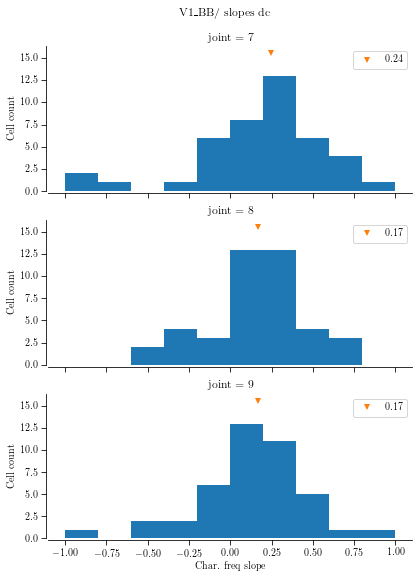

In [1560]:
f, ax = plt.subplots(3,1,figsize=hf.set_size(tex_width, subplots=(3,1), extra_height=0.75), sharex=True, sharey=True);

bins = np.linspace(-1,1,11);

f.suptitle('%s slopes%s' % (expDir.replace('_','\_'), ' %s' % rsp if 'BB' in expDir else ''),y=hist_ytitle) 

for (i,s),lbl in zip(enumerate(slps), joint):
    
    clipped = np.clip(s,bins[0],bins[-1]);
    oy = ax[i].hist(clipped, bins=bins)
    ax[i].plot(np.nanmedian(clipped), 1.2*np.nanmax(oy[0]), 'v', label='%.2f' % np.nanmedian(clipped))
    ax[i].legend()
    ax[i].set_title('joint = %d' % lbl)
    sns.despine(offset=sns_offset)
    ax[i].set_ylabel('Cell count')
    if i==len(slps)-1:
        ax[i].set_xlabel('Char. freq slope')
        
saveName = "/%s%s.pdf" % (expDir.replace('/',''), '_%s' % rsp if 'BB' in expDir else '')
full_save = os.path.dirname(save_loc + '02_debug_slopes/');
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Quick analysis (22.07.16) on reliability of slope estimates
In the below, we load two different versions of the same fits (with or without explained variance {vE} restrictions), and check how reliable the slope estimates are. We learned that for neurons that "make the cut" on explained variance, the slope estimates are very reliable, even when including all contrasts. Thus, the differences in slope estimates between repeats largely stem from neurons that have very few (if any) contrasts with clean data.

In later dates, expanded to compare vExp vs. non vExp fits; and differently parameterized fits.

__Be sure to adjust the below (e.g. labels, save name) if changing the comparison__

In [1561]:
# isBB = False;
# metr = 'dc' # only applicable if isBB

# if isBB:
#     ek = hf.np_smart_load('V1_BB/structures/descrFitsHPC_220718_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
#     do = hf.np_smart_load('V1_BB/structures/descrFitsHPC_220718vEs_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
    
#     oy  = np.array([-ek[x][metr]['mask']['paramList'][1] if ~np.all(np.isnan(ek[x][metr]['mask']['paramList'])) else np.nan for x in range(47)])
#     vey = np.array([-do[x][metr]['mask']['paramList'][1] if ~np.all(np.isnan(do[x][metr]['mask']['paramList'])) else np.nan  for x in range(47)])
    
#     # the below are the simple cells...
#     val_cells = np.array([1,3,4,5,10,11,12,21,25,26,27,28,29,30,31,32,33,34,35,36,37,40,41,42,43,45,47])-1
#     if metr=='dc':
#         val_cells = np.setxor1d(val_cells, np.arange(47))
# else:
#     ek = hf.np_smart_load('V1/structures/descrFitsHPC_220718vEs_phAdj_sqrt_sach_JTsurrShapeCtrRaSlope.npy')
#     do = hf.np_smart_load('V1/structures/descrFitsHPC_220720vEs_phAdj_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
#     oy  = np.array([-ek[x]['paramList'][0][1] if ~np.all(np.isnan(ek[x]['paramList'][0])) else np.nan for x in range(81)])
    
#     vey = np.array([-do[x]['paramList'][0][1] if ~np.all(np.isnan(do[x]['paramList'][0])) else np.nan  for x in range(81)])

In [1562]:
# ok_inds = np.where(np.logical_and(~np.isnan(oy), ~np.isnan(vey)))[0];

# # type_inds = np.where(np.intersect1d(np.arange(47), val_cells))
# # ok_inds = np.intersect1d(type_inds, ok_inds)

In [1563]:
# # cc = np.corrcoef(hf.nan_rm(oy),hf.nan_rm(vey))
# cc = np.corrcoef(oy[ok_inds],vey[ok_inds])

In [1564]:
# plt.figure(figsize=hf.set_size(tex_width));
# plt.xlabel('slope dog')
# plt.ylabel('slope d-DoG-S')
# plt.scatter(oy[ok_inds], vey[ok_inds], alpha=0.1, color='k')
# plt.axis('scaled');
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.title('Comp. varExpl vs. not, r=%.2f [n=%d]' % (cc[0,1], len(oy[ok_inds])));
# # plt.title('Comp. varExpl vs. not, r=%.2f [n=%d]' % (cc[0,1], len(oy[ok_inds])));
# plt.plot([-1,1], [-1,1], 'k--', alpha=0.3)

# metr_str = '_%s' % metr if isBB else '';

# saveName = "/slope_comps_v1%s_DoG_dDoGs_vEs%s.pdf" % ('bb' if isBB else '', metr_str)
# full_save = os.path.dirname(save_loc + '../'); # don't save in the jointList-specific folder...
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(plt.gcf()) # only one figure here...
# pdfSv.close()

##### Quick comparison of loss for two models...

In [1565]:
# ek = hf.np_smart_load('V1/structures/descrFitsHPC_220718vEs_phAdj_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')
# do = hf.np_smart_load('V1/structures/descrFitsHPC_220719vEs_phAdj_sqrt_ddogs_JTflankFixedCopyCtrRaSlope.npy')

# le = np.array([ek[x]['totalNLL'][0] for x in range(81)])
# lo = np.array([do[x]['totalNLL'][0] for x in range(81)])


In [1566]:
# np.nanmedian(100*(le-lo)/le)

In [1567]:
# sns.distplot((le-lo)/le, bins=np.linspace(-.1,0.1,6))